### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000021B23BC10D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 3: ML modeling 

ASSUMPTION: run *02_PreProcessing_and_ML_modeling.ipynb* for datasets ESC-10, BDLib2 and US8k

***

## Importe modules

In [2]:
import mimetypes
import warnings
import os
import pickle
import time
import random

import pandas          as pd
import numpy           as np
import seaborn         as sns

from matplotlib  import pyplot as plt

from matplotlib.patches        import Patch
from collections               import Counter
from sklearn.model_selection   import StratifiedKFold, StratifiedShuffleSplit, KFold, learning_curve, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn                   import preprocessing
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn                   import metrics


In [3]:
# Solution to play .ogg files in the IPython 
# https://stackoverflow.com/questions/39077987/ipython-display-audio-cannot-correctly-handle-ogg-file-type

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [4]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '03_ML_modeling_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

In [5]:
current_path

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master'

## Loading the dataset


In [6]:
# Select the dataset

opc = 0
while str(opc) not in '123':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'

    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'

    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 3


In [7]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [8]:
from MT_loadDataset import loadDataset

In [9]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


CSV exported.
Check the folder :  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K

Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Total number of unique files..........:  8732
Total number of AUDIO files...........:  8732


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-2-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-2-0.wav,1,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-3-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-3-0.wav,1,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-4-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-4-0.wav,1,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-5-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-5-0.wav,1,99812,253.209850,255.741948,2


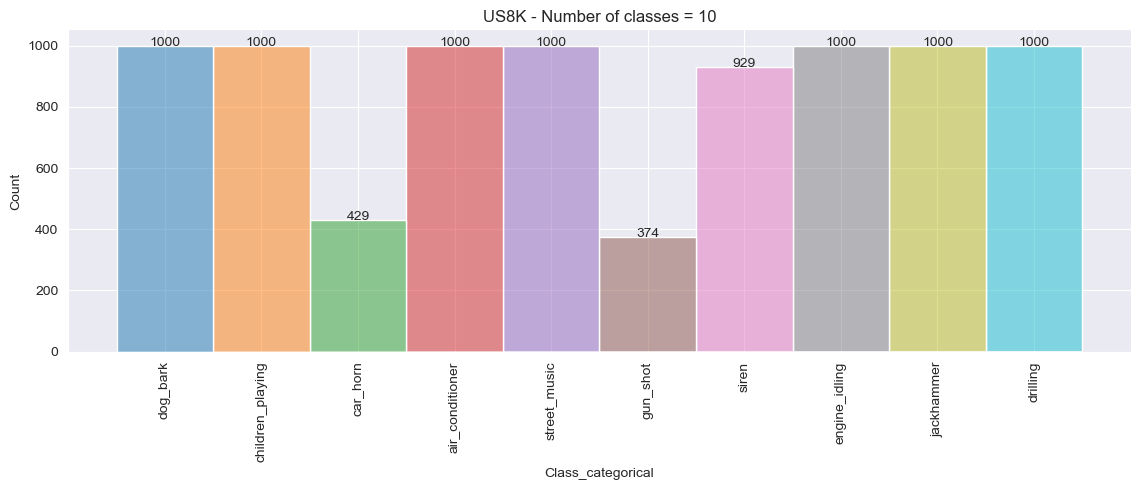

In [10]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [11]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K only windowed)

Select the dataset: 3


In [12]:
DB_from_pkl.dtypes

Audio                  object
Class_categorical      object
Class_OHEV             object
Fold                   object
RMSE                  float64
                       ...   
TONNETZ_6             float64
TONNETZ_std_6         float64
TONNETZ_median_6      float64
TONNETZ_skew_6        float64
TONNETZ_kurtosis_6    float64
Length: 379, dtype: object

## Input split

In [13]:
# Separate 1 fold for validation and create a DB for the training / testing according to the datasets specification

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

In [14]:
print(len(DB_from_pkl_VAL))
print(len(DB_from_pkl_TRN))
print('Total: ', len(DB_from_pkl_VAL) + len(DB_from_pkl_TRN),'\n')

6111
55013
Total:  61124 



In [15]:
DB_from_pkl_VAL

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
448,"[6.402111e-05, 8.269498e-05, 5.2123058e-05, 7.1509836e-05, 3.3138364e-05, -6.1828905e-07, -8.950657e-05, -9.0291964e...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.020142,0.031516,1152.318462,1898.286145,2047.611861,0.000215,...,-0.025755,0.022838,-0.026786,-0.052399,0.615014,0.008609,0.019867,0.005833,0.230194,-0.774566
449,"[0.0005136457, 0.00041881658, 0.00034897702, 0.00021603762, 0.0002278979, 0.00011100468, 0.00010083006, 0.0001630317...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.035680,0.036821,1237.588550,1949.387843,2185.620117,0.000149,...,-0.019544,0.025159,-0.019644,-0.651683,0.800014,0.007915,0.018672,0.009202,0.529034,0.970660
450,"[-5.3512427e-05, 2.2222208e-05, 2.7161423e-05, 0.00017825539, 0.00032240857, 0.00041231932, 0.0005614782, 0.00053010...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.036087,0.045854,1422.395537,2117.020765,2954.942738,0.000164,...,-0.054370,0.025735,-0.047586,-1.318172,1.632758,-0.027509,0.030452,-0.029692,0.291676,-0.927084
451,"[-9.721824e-05, -0.0002176053, -0.00031682133, -0.00042641407, -0.00044769727, -0.00042776082, -0.00044338158, -0.00...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.000778,0.040949,1877.232022,2785.436746,4904.676403,0.000262,...,-0.030969,0.007624,-0.032476,0.155556,-0.770907,-0.012053,0.031560,-0.005922,-0.290679,-1.082696
452,"[0.00023775743, 0.00023206181, 0.00023593163, 0.00017538742, 0.00011133426, 0.00021567091, 0.00011633049, 8.274122e-...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.076167,0.042880,1592.015997,2199.860601,3819.696600,0.000478,...,0.000732,0.044018,-0.017289,1.031027,0.270565,0.010252,0.030058,0.002691,1.003930,1.476461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60762,"[-0.28165075, -0.39413118, -0.48126578, -0.54062337, -0.5627302, -0.5343282, -0.45225257, -0.33417547, -0.2137392, -...",street_music,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.197044,0.070557,1087.442478,886.308473,2116.371294,0.097209,...,-0.061880,0.031519,-0.056552,-0.351484,-0.625515,0.017365,0.029579,0.014569,0.348922,-0.837185
60763,"[-0.74769396, -0.725761, -0.69069016, -0.64954436, -0.6015309, -0.53891814, -0.45484614, -0.35106456, -0.23903547, -...",street_music,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.197267,0.073486,1114.525841,940.949276,2165.065696,0.074330,...,-0.062628,0.031725,-0.065875,0.253447,-0.539902,0.019380,0.023069,0.014551,0.736680,0.175157
60764,"[-0.0073982505, 0.00089106406, 0.0060087573, -0.0026300459, -0.028010733, -0.059386022, -0.07765661, -0.06947853, -0...",street_music,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.196901,0.072865,1059.255494,857.858019,2070.857932,0.070687,...,-0.077710,0.037631,-0.080120,0.035094,-0.850222,0.036699,0.032426,0.030839,0.338930,-0.276007
60765,"[-0.19841202, -0.19705483, -0.20790972, -0.22519125, -0.2374166, -0.23624307, -0.2194226, -0.18771836, -0.14198783, ...",street_music,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.192756,0.066939,1058.530590,902.456226,2027.791526,0.077644,...,-0.062108,0.044052,-0.055218,-0.356556,-0.980263,0.096174,0.053901,0.111005,-0.161630,-1.176320


In [16]:
DB_from_pkl_TRN

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.117183,0.129483,2069.471399,1734.789901,2861.958452,0.000172,...,-0.027402,0.036064,-0.027793,-0.105702,-0.542892,-0.046177,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.111724,0.131570,2098.418718,1743.608984,2885.449219,0.000047,...,-0.024680,0.026742,-0.021896,-0.009029,-0.613116,-0.026347,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.124646,0.131459,2096.616414,1747.412264,2877.618963,0.000173,...,-0.022529,0.029269,-0.019908,-0.041418,-0.757713,-0.045096,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.110741,0.131658,2093.378630,1736.615179,2873.214444,0.000026,...,-0.029242,0.026361,-0.024858,-0.293476,-0.509338,-0.020052,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.125728,0.131836,2105.951159,1750.491381,2885.693914,0.000831,...,-0.027311,0.028995,-0.029214,-0.145633,-0.282959,-0.032483,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61119,"[-0.024376377, -0.010054192, 0.0009410139, 0.005863713, -0.0005189497, -0.0021953415, 0.0013682423, -0.0043018945, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.012771,0.165439,2435.099768,2199.072455,4209.741211,0.041714,...,0.022133,0.021647,0.022897,0.105963,-0.457640,-0.066230,0.033488,-0.069738,0.175013,-0.974133
61120,"[0.0066777063, 0.008175363, 0.006157635, 0.0026387093, 0.00059039844, 0.0030925209, 0.0033645788, 0.0056151543, 0.00...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007954,0.148016,2363.629594,2317.859881,4304.193670,0.055727,...,0.044053,0.014626,0.045769,-0.351788,-0.679147,-0.022097,0.021007,-0.018432,-0.690702,-0.099409
61121,"[-0.0020232266, 0.001032982, 0.0023606261, 0.0017964527, 0.0009908059, -0.0011728329, -0.003362489, -0.0054453667, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.008383,0.154519,2389.715351,2316.671469,4391.060569,0.036835,...,0.022832,0.013426,0.021000,0.434590,-0.457858,-0.013611,0.021124,-0.016391,-0.028383,-1.071243
61122,"[-0.0015619812, 0.0005301243, 0.0032789772, 0.002725502, 0.0023546133, -0.0019822496, -0.002666029, -0.004454969, -0...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.010459,0.173873,2467.091641,2211.234749,4411.125599,0.021755,...,0.009672,0.011971,0.008398,0.766553,0.517087,-0.012274,0.027106,-0.017513,-0.121982,-0.606880


In [17]:
for i in DB_from_pkl_TRN.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [18]:
# Separating data and labels

X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

In [19]:
# For the augmented dataset (only validation set)

X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

In [20]:
X

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,0.117183,0.129483,2069.471399,1734.789901,2861.958452,0.000172,0.000326,0.000416,0.000709,0.000580,...,-0.027402,0.036064,-0.027793,-0.105702,-0.542892,-0.046177,0.025644,-0.046785,0.461191,-0.338882
1,0.111724,0.131570,2098.418718,1743.608984,2885.449219,0.000047,0.000228,0.000322,0.000599,0.000533,...,-0.024680,0.026742,-0.021896,-0.009029,-0.613116,-0.026347,0.026433,-0.030688,0.414979,-0.840459
2,0.124646,0.131459,2096.616414,1747.412264,2877.618963,0.000173,0.000376,0.000453,0.000821,0.000707,...,-0.022529,0.029269,-0.019908,-0.041418,-0.757713,-0.045096,0.023640,-0.045384,0.629947,0.096665
3,0.110741,0.131658,2093.378630,1736.615179,2873.214444,0.000026,0.000210,0.000282,0.000549,0.000491,...,-0.029242,0.026361,-0.024858,-0.293476,-0.509338,-0.020052,0.024617,-0.025407,0.554764,-0.364067
4,0.125728,0.131836,2105.951159,1750.491381,2885.693914,0.000831,0.001138,0.001241,0.001559,0.001575,...,-0.027311,0.028995,-0.029214,-0.145633,-0.282959,-0.032483,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61119,0.012771,0.165439,2435.099768,2199.072455,4209.741211,0.041714,0.046895,0.049507,0.047384,0.039898,...,0.022133,0.021647,0.022897,0.105963,-0.457640,-0.066230,0.033488,-0.069738,0.175013,-0.974133
61120,0.007954,0.148016,2363.629594,2317.859881,4304.193670,0.055727,0.070617,0.056094,0.040240,0.033771,...,0.044053,0.014626,0.045769,-0.351788,-0.679147,-0.022097,0.021007,-0.018432,-0.690702,-0.099409
61121,0.008383,0.154519,2389.715351,2316.671469,4391.060569,0.036835,0.067511,0.118632,0.128893,0.173377,...,0.022832,0.013426,0.021000,0.434590,-0.457858,-0.013611,0.021124,-0.016391,-0.028383,-1.071243
61122,0.010459,0.173873,2467.091641,2211.234749,4411.125599,0.021755,0.042709,0.149269,0.175648,0.207281,...,0.009672,0.011971,0.008398,0.766553,0.517087,-0.012274,0.027106,-0.017513,-0.121982,-0.606880


In [21]:
X.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,...,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000
mean,0.068962,0.119914,2126.164356,2095.301985,4096.136380,1.587649e+01,1.551829e+01,1.067019e+01,7.053240e+00,7.479396e+00,...,0.000670,0.025401,0.000642,0.005264,-0.361158,-0.000951,0.025222,-0.001939,0.093688,-0.377126
std,0.068355,0.094113,1026.349090,572.007000,2002.767161,1.005021e+02,7.051266e+01,4.155996e+01,2.696642e+01,3.234189e+01,...,0.040087,0.019087,0.041704,0.558679,1.094642,0.036431,0.018768,0.038278,0.538735,0.936972
min,0.000145,0.000000,212.399183,478.380671,202.852561,2.185136e-08,1.265428e-08,1.539058e-08,1.382298e-08,3.202950e-08,...,-0.302369,0.003082,-0.335022,-3.233604,-1.906979,-0.178633,0.002233,-0.208415,-4.493470,-1.900563
25%,0.022730,0.059948,1411.820545,1673.140188,2561.961781,2.137662e-02,5.338410e-02,6.389216e-02,7.190919e-02,7.302918e-02,...,-0.016680,0.015130,-0.016799,-0.322968,-0.937097,-0.019760,0.015174,-0.021128,-0.238506,-0.932242
50%,0.050379,0.092574,1871.014564,2050.329867,3670.187655,2.307109e-01,5.659199e-01,7.411505e-01,6.698897e-01,6.251277e-01,...,0.001255,0.020287,0.001387,-0.000591,-0.569421,-0.001630,0.020268,-0.002374,0.083737,-0.564106
75%,0.090281,0.142911,2574.241496,2517.625774,5432.729270,2.269010e+00,5.635880e+00,5.304951e+00,3.667604e+00,3.680416e+00,...,0.019641,0.029116,0.020035,0.319146,-0.079507,0.016748,0.028754,0.016174,0.413050,-0.077914
max,0.796355,0.669522,6674.189171,4340.169312,10066.772461,3.744774e+03,2.869256e+03,7.940164e+02,8.580748e+02,1.159883e+03,...,0.257914,0.276190,0.293074,4.102256,23.766326,0.295177,0.257286,0.314713,3.704167,21.586886


In [22]:
y

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'car_horn', 'car_horn',
       'car_horn'], dtype='<U16')

In [23]:
X_norm = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [24]:
X_standard = X.apply(lambda x: (x - x.mean()) / x.std())

In [25]:
X_norm.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,...,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000
mean,0.086430,0.179104,0.296166,0.418698,0.394699,0.004240,0.005408,0.013438,0.008220,0.006448,...,0.540867,0.081724,0.534416,0.441512,0.060211,0.375007,0.090137,0.394694,0.559571,0.064862
std,0.085850,0.140568,0.158834,0.148120,0.203040,0.026838,0.024575,0.052341,0.031427,0.027884,...,0.071549,0.069888,0.066397,0.076157,0.042637,0.076890,0.073586,0.073172,0.065718,0.039892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.028365,0.089538,0.185618,0.309380,0.239165,0.000006,0.000019,0.000080,0.000084,0.000063,...,0.509900,0.044113,0.506648,0.396768,0.037778,0.335309,0.050739,0.358013,0.519048,0.041227
50%,0.063091,0.138268,0.256680,0.407052,0.351517,0.000062,0.000197,0.000933,0.000781,0.000539,...,0.541912,0.062997,0.535602,0.440714,0.052099,0.373573,0.070711,0.393863,0.558357,0.056901
75%,0.113206,0.213452,0.365509,0.528057,0.530203,0.000606,0.001964,0.006681,0.004274,0.003173,...,0.574728,0.095325,0.565291,0.484299,0.071182,0.412362,0.103983,0.429318,0.598528,0.077601
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
X_standard.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,...,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04
mean,2.686508e-17,7.439562e-17,-9.092798e-17,-7.646216e-16,-1.591240e-16,1.343254e-17,2.479854e-17,3.926435e-17,2.273199e-17,-1.239927e-17,...,-7.232907e-18,-1.033272e-17,-1.963218e-17,2.221536e-17,5.424681e-18,1.188263e-17,-1.756563e-16,1.343254e-17,7.232907e-18,-7.878703e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.006752e+00,-1.274150e+00,-1.864634e+00,-2.826751e+00,-1.943952e+00,-1.579717e-01,-2.200781e-01,-2.567421e-01,-2.615564e-01,-2.312603e-01,...,-7.559444e+00,-1.169356e+00,-8.048750e+00,-5.797369e+00,-1.412169e+00,-4.877191e+00,-1.224910e+00,-5.394053e+00,-8.514677e+00,-1.625916e+00
25%,-6.763530e-01,-6.371765e-01,-6.960047e-01,-7.380361e-01,-7.660274e-01,-1.577590e-01,-2.193210e-01,-2.552047e-01,-2.588898e-01,-2.290023e-01,...,-4.328077e-01,-5.381588e-01,-4.182106e-01,-5.875161e-01,-5.261435e-01,-5.162964e-01,-5.353890e-01,-5.012984e-01,-6.166193e-01,-5.924574e-01
50%,-2.718578e-01,-2.905084e-01,-2.485994e-01,-7.862162e-02,-2.126801e-01,-1.556762e-01,-2.120523e-01,-2.389088e-01,-2.367148e-01,-2.119316e-01,...,1.460347e-02,-2.679569e-01,1.786043e-02,-1.048129e-02,-1.902564e-01,-1.865305e-02,-2.639856e-01,-1.135903e-02,-1.847203e-02,-1.995578e-01
75%,3.118906e-01,2.443509e-01,4.365738e-01,7.383193e-01,6.673731e-01,-1.353950e-01,-1.401509e-01,-1.290963e-01,-1.255501e-01,-1.174631e-01,...,4.732518e-01,1.946117e-01,4.650054e-01,5.618273e-01,2.573003e-01,4.858222e-01,1.881661e-01,4.731923e-01,5.927980e-01,3.193399e-01
max,1.064142e+01,5.839857e+00,4.431265e+00,3.924545e+00,2.981193e+00,3.710268e+01,4.047128e+01,1.884858e+01,3.155856e+01,3.563192e+01,...,6.417085e+00,1.313923e+01,7.012087e+00,7.333355e+00,2.204143e+01,8.128403e+00,1.236456e+01,8.272375e+00,6.701767e+00,2.344149e+01


In [27]:
X_norm = X_norm.values

In [28]:
X_standard = X_standard.values

In [29]:
X_norm.shape

(55013, 375)

In [30]:
X_standard.shape

(55013, 375)

In [31]:
y.shape

(55013,)

In [32]:
len(X_norm)

55013

In [33]:
len(X_standard)

55013

In [34]:
X_val

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
448,0.020142,0.031516,1152.318462,1898.286145,2047.611861,0.000215,0.003187,0.009138,0.009977,0.004333,...,-0.025755,0.022838,-0.026786,-0.052399,0.615014,0.008609,0.019867,0.005833,0.230194,-0.774566
449,0.035680,0.036821,1237.588550,1949.387843,2185.620117,0.000149,0.003281,0.008490,0.013581,0.010573,...,-0.019544,0.025159,-0.019644,-0.651683,0.800014,0.007915,0.018672,0.009202,0.529034,0.970660
450,0.036087,0.045854,1422.395537,2117.020765,2954.942738,0.000164,0.003183,0.008720,0.012922,0.010302,...,-0.054370,0.025735,-0.047586,-1.318172,1.632758,-0.027509,0.030452,-0.029692,0.291676,-0.927084
451,0.000778,0.040949,1877.232022,2785.436746,4904.676403,0.000262,0.003827,0.008330,0.004109,0.000948,...,-0.030969,0.007624,-0.032476,0.155556,-0.770907,-0.012053,0.031560,-0.005922,-0.290679,-1.082696
452,0.076167,0.042880,1592.015997,2199.860601,3819.696600,0.000478,0.005926,0.013878,0.011063,0.006405,...,0.000732,0.044018,-0.017289,1.031027,0.270565,0.010252,0.030058,0.002691,1.003930,1.476461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60762,0.197044,0.070557,1087.442478,886.308473,2116.371294,0.097209,0.143938,0.931407,2.012327,4.058342,...,-0.061880,0.031519,-0.056552,-0.351484,-0.625515,0.017365,0.029579,0.014569,0.348922,-0.837185
60763,0.197267,0.073486,1114.525841,940.949276,2165.065696,0.074330,0.137826,0.723872,2.136309,5.123062,...,-0.062628,0.031725,-0.065875,0.253447,-0.539902,0.019380,0.023069,0.014551,0.736680,0.175157
60764,0.196901,0.072865,1059.255494,857.858019,2070.857932,0.070687,0.032660,1.051862,3.447621,5.921270,...,-0.077710,0.037631,-0.080120,0.035094,-0.850222,0.036699,0.032426,0.030839,0.338930,-0.276007
60765,0.192756,0.066939,1058.530590,902.456226,2027.791526,0.077644,0.018916,0.504472,3.028391,5.707320,...,-0.062108,0.044052,-0.055218,-0.356556,-0.980263,0.096174,0.053901,0.111005,-0.161630,-1.176320


In [35]:
X_val.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6.111000e+03,6.111000e+03,6.111000e+03,6111.000000,6111.000000,...,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000
mean,0.068437,0.121839,2157.020267,2111.610121,4149.329855,8.763791e+00,1.444894e+01,1.357042e+01,10.951914,9.974779,...,0.001626,0.029366,0.001724,0.005499,-0.403005,0.006016,0.029518,0.004002,0.081200,-0.379917
std,0.059505,0.104305,1156.119316,615.631721,2162.251031,3.906713e+01,8.113987e+01,9.014331e+01,49.517925,25.926782,...,0.038178,0.031707,0.039647,0.532226,0.909987,0.038065,0.031401,0.042485,0.555910,0.911725
min,0.000083,0.000000,233.834587,695.196438,250.812877,1.565859e-07,3.164050e-07,6.580975e-07,0.000002,0.000002,...,-0.183272,0.003144,-0.201818,-2.799329,-1.837342,-0.152527,0.003733,-0.178653,-2.506518,-1.778544
25%,0.023579,0.053944,1292.922795,1666.714121,2430.682650,2.361467e-02,3.819560e-02,4.073115e-02,0.055783,0.064155,...,-0.015788,0.014709,-0.015677,-0.309233,-0.960693,-0.015044,0.015402,-0.016608,-0.266185,-0.951456
50%,0.050098,0.092973,1941.889399,2092.701266,3738.947088,2.700887e-01,3.025362e-01,4.565277e-01,0.432893,0.509790,...,0.002249,0.020248,0.002340,0.017542,-0.589777,0.002424,0.020244,0.001544,0.063558,-0.575697
75%,0.099826,0.146684,2620.645723,2610.517954,5620.166016,1.782244e+00,5.911274e+00,5.205619e+00,4.948398,4.816772,...,0.019522,0.029975,0.019336,0.317772,-0.100087,0.020247,0.029658,0.019470,0.428042,-0.049214
max,0.469498,0.852517,6970.974319,3658.796731,10363.588090,8.491414e+02,2.717278e+03,3.085914e+03,1875.224487,352.115082,...,0.177249,0.219337,0.218364,3.105836,10.715391,0.237573,0.227059,0.235507,2.530284,12.081950


In [36]:
y_val

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'street_music',
       'street_music', 'street_music'], dtype='<U16')

In [37]:
X_val_norm = X_val.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [38]:
X_val_standard = X_val.apply(lambda x: (x - x.mean()) / x.std())

In [39]:
X_val_norm.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,...,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000
mean,0.145616,0.142917,0.285460,0.477937,0.385504,0.010321,0.005317,0.004398,0.005840,0.028328,...,0.512863,0.121290,0.484415,0.474979,0.114265,0.406418,0.115459,0.441025,0.513762,0.100907
std,0.126765,0.122350,0.171604,0.207731,0.213814,0.046008,0.029861,0.029211,0.026406,0.073632,...,0.105896,0.146658,0.094356,0.090129,0.072493,0.097578,0.140606,0.102582,0.110370,0.065779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050053,0.063276,0.157201,0.327817,0.215556,0.000028,0.000014,0.000013,0.000030,0.000182,...,0.464560,0.053495,0.443002,0.421681,0.069837,0.352430,0.052253,0.391264,0.444793,0.059672
50%,0.106548,0.109057,0.253528,0.471556,0.344924,0.000318,0.000111,0.000148,0.000231,0.001448,...,0.514591,0.079114,0.485880,0.477018,0.099386,0.397209,0.073933,0.435091,0.510259,0.086782
75%,0.212483,0.172060,0.354277,0.646282,0.530948,0.002099,0.002175,0.001687,0.002639,0.013680,...,0.562501,0.124106,0.526331,0.527860,0.138397,0.442898,0.116089,0.478374,0.582624,0.124767
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
X_val_standard.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,...,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03,6111.000000,6.111000e+03,6.111000e+03,6.111000e+03,6.111000e+03
mean,-5.581092e-17,7.441456e-17,5.581092e-17,-7.441456e-17,-4.836946e-16,2.325455e-17,9.301819e-18,9.301819e-18,-9.301819e-18,5.581092e-17,...,3.720728e-17,-3.720728e-17,9.301819e-18,-4.650910e-18,-8.022819e-17,0.000000,7.441456e-17,-9.301819e-18,-9.301819e-18,3.255637e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.148709e+00,-1.168105e+00,-1.663484e+00,-2.300748e+00,-1.802990e+00,-2.243264e-01,-1.780745e-01,-1.505427e-01,-2.211707e-01,-3.847287e-01,...,-4.843097e+00,-8.270243e-01,-5.133928e+00,-5.269998e+00,-1.576217e+00,-4.165070,-8.211557e-01,-4.299241e+00,-4.654926e+00,-1.534044e+00
25%,-7.538614e-01,-6.509299e-01,-7.474120e-01,-7.226658e-01,-7.948417e-01,-2.237220e-01,-1.776037e-01,-1.500909e-01,-2.200442e-01,-3.822543e-01,...,-4.561423e-01,-4.622668e-01,-4.389031e-01,-5.913494e-01,-6.128533e-01,-0.553277,-4.495296e-01,-4.850864e-01,-6.248944e-01,-6.268759e-01
50%,-3.081938e-01,-2.767470e-01,-1.860802e-01,-3.071456e-02,-1.897942e-01,-2.174130e-01,-1.743459e-01,-1.454783e-01,-2.124286e-01,-3.650661e-01,...,1.631320e-02,-2.875818e-01,1.552652e-02,2.262921e-02,-2.052474e-01,-0.094373,-2.953403e-01,-5.784490e-02,-3.173565e-02,-2.147356e-01
75%,5.274879e-01,2.381934e-01,4.010187e-01,8.103998e-01,6.802338e-01,-1.787064e-01,-1.052216e-01,-9.279447e-02,-1.212392e-01,-1.989451e-01,...,4.687481e-01,1.920280e-02,4.442277e-01,5.867314e-01,3.328812e-01,0.373857,4.479432e-03,3.640878e-01,6.239176e-01,3.627227e-01
max,6.739925e+00,7.005191e+00,4.163890e+00,2.513169e+00,2.873976e+00,2.151112e+01,3.331074e+01,3.408288e+01,3.764844e+01,1.319640e+01,...,4.600158e+00,5.991544e+00,5.464270e+00,5.825231e+00,1.221819e+01,6.083180,6.290933e+00,5.449053e+00,4.405545e+00,1.366844e+01


In [41]:
X_val_norm = X_val_norm.values

In [42]:
X_val_standard = X_val_standard.values

In [43]:
X_val_norm.shape

(6111, 375)

In [44]:
X_val_standard.shape

(6111, 375)

In [45]:
y_val.shape

(6111,)

In [46]:
len(y_val)

6111

In [47]:
Counter_val = Counter(y_val)
Counter_val

Counter({'dog_bark': 700,
         'gun_shot': 245,
         'jackhammer': 840,
         'engine_idling': 672,
         'children_playing': 700,
         'siren': 602,
         'street_music': 700,
         'air_conditioner': 700,
         'drilling': 700,
         'car_horn': 252})

In [48]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
air_conditioner    27717    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
car_horn           9179     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
children_playing   15763    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
dog_bark           26221    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
drilling           1456     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
engine_idling      4488     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
gun_shot           36181    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
jackhammer         49982    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
siren              44603    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
street_music       14609    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'air_conditioner': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'drilling': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'engine_idling': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'gun_shot': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'jackhammer': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'siren': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'street_music': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [49]:
nom_classes = list(encoder_dict.keys())
nom_classes

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

## StratifiedKFold

It is used for performing stratified k-fold cross-validation. It divides your dataset into 'k' equal-sized folds while ensuring that each fold maintains the same class distribution as the original dataset. This technique is valuable when you have a limited amount of data, and you want to maximize the use of your data for training and testing by creating multiple train-test splits.

Key points about StratifiedKFold:

- It's typically used for model evaluation, especially when you have a small dataset.
- You specify the number of folds (n_splits), and it creates 'k' folds with each fold maintaining the class distribution.
- It's used in conjunction with cross-validation functions like cross_val_score or cross_validate to assess your model's performance.

## StratifiedShuffleSplit 

It is primarily used for creating random train-test splits while ensuring that the class distribution is maintained in both the training and testing sets. This is particularly useful when you have a relatively large dataset and want to create multiple random splits to evaluate your model's performance or perform hyperparameter tuning.

Key points about StratifiedShuffleSplit:

- It randomly shuffles the data and splits it into train and test sets, preserving the class distribution.
- You specify the number of splits (n_splits), the test set size or proportion (test_size), and can optionally set a random seed for reproducibility.
- It's commonly used for tasks like model evaluation, cross-validation, and hyperparameter tuning.

In [50]:
N_SPLITS  = 5
cmap_data = plt.cm.viridis
cmap_cv   = plt.cm.coolwarm
cmap_cm   = plt.cm.Blues

sss = StratifiedShuffleSplit(n_splits = N_SPLITS, test_size=0.1, random_state=100)
skf = StratifiedKFold(n_splits = N_SPLITS, random_state=None, shuffle=False)
kfd = KFold(N_SPLITS)

In [51]:
sss

StratifiedShuffleSplit(n_splits=5, random_state=100, test_size=0.1,
            train_size=None)

In [52]:
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [53]:
kfd

KFold(n_splits=5, random_state=None, shuffle=False)

In [54]:
# Creates the train / test split
for idx_trn, idx_tst in sss.split(X_norm, y):
    X_train      = X_norm[idx_trn]
    X_test       = X_norm[idx_tst]
    y_train      = y[idx_trn]
    y_test       = y[idx_tst]
    y_train_OHEV = y_OHEV[idx_trn]
    y_test_OHEV  = y_OHEV[idx_tst]

In [55]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_train_OHEV))
print(np.shape(y_test_OHEV))

(49511, 375)
(5502, 375)
(49511,)
(5502,)
(49511, 10)
(5502, 10)


In [56]:
X_train

array([[0.08415578, 0.22926474, 0.39262854, ..., 0.43066601, 0.52583539,
        0.05066574],
       [0.10827147, 0.39043957, 0.58481225, ..., 0.47935548, 0.60929099,
        0.06591681],
       [0.06950413, 0.50656368, 0.64476999, ..., 0.43598487, 0.47659167,
        0.07564013],
       ...,
       [0.0074466 , 0.25903335, 0.35179159, ..., 0.37680371, 0.62537797,
        0.04798794],
       [0.05091949, 0.04853146, 0.24488063, ..., 0.33957979, 0.66917958,
        0.10490958],
       [0.04074176, 0.05622224, 0.27314803, ..., 0.30932257, 0.62932529,
        0.02895399]])

In [57]:
y_train

array(['jackhammer', 'jackhammer', 'jackhammer', ..., 'siren',
       'engine_idling', 'engine_idling'], dtype='<U16')

In [58]:
y_train_OHEV

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [59]:
for i in y_test:
    print(i)

siren
engine_idling
street_music
jackhammer
jackhammer
air_conditioner
drilling
children_playing
car_horn
street_music
drilling
engine_idling
dog_bark
siren
gun_shot
gun_shot
street_music
dog_bark
children_playing
street_music
air_conditioner
siren
drilling
siren
engine_idling
jackhammer
street_music
street_music
children_playing
drilling
drilling
drilling
dog_bark
drilling
car_horn
street_music
air_conditioner
drilling
drilling
drilling
children_playing
jackhammer
car_horn
siren
siren
air_conditioner
air_conditioner
jackhammer
jackhammer
siren
drilling
gun_shot
engine_idling
air_conditioner
dog_bark
air_conditioner
jackhammer
siren
drilling
car_horn
drilling
siren
jackhammer
street_music
air_conditioner
air_conditioner
jackhammer
street_music
drilling
jackhammer
children_playing
street_music
jackhammer
dog_bark
dog_bark
jackhammer
air_conditioner
jackhammer
car_horn
car_horn
street_music
jackhammer
air_conditioner
street_music
children_playing
children_playing
drilling
drilling
drilli

In [60]:
y_test[0]

'siren'

In [61]:
list_counter_test = Counter(y_test)
list_counter_test

Counter({'siren': 590,
         'engine_idling': 633,
         'street_music': 630,
         'jackhammer': 616,
         'air_conditioner': 630,
         'drilling': 630,
         'children_playing': 630,
         'car_horn': 275,
         'dog_bark': 630,
         'gun_shot': 238})

In [62]:
list_counter_test_OHEV = Counter(map(tuple, y_test_OHEV))
list_counter_test_OHEV

Counter({(0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 590,
         (0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 633,
         (0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 630,
         (0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 616,
         (1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 630,
         (0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 630,
         (0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 630,
         (0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 275,
         (0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 630,
         (0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 238})

In [63]:
list_counter_train = Counter(y_train)
list_counter_train

Counter({'jackhammer': 5544,
         'car_horn': 2476,
         'engine_idling': 5695,
         'siren': 5311,
         'dog_bark': 5670,
         'gun_shot': 2135,
         'street_music': 5670,
         'air_conditioner': 5670,
         'children_playing': 5670,
         'drilling': 5670})

In [64]:
list_counter_train_OHEV = Counter(map(tuple, y_train_OHEV))
list_counter_train_OHEV

Counter({(0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 5544,
         (0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 2476,
         (0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 5695,
         (0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 5311,
         (0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 5670,
         (0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 2135,
         (0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 5670,
         (1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 5670,
         (0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 5670,
         (0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 5670})

### Mutual information

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

A quantity called mutual information measures the amount of information one can obtain from one random variable given another.

The mutual information between two random variables X and Y can be stated formally as follows:

\begin{aligned}
I(X ; Y) = H(X) – H(X | Y)
\end{aligned}

Where $I(X ; Y)$ is the mutual information for $X$ and $Y$, $H(X)$ is the entropy for $X$ and $H(X | Y)$ is the conditional entropy for $X$ given $Y$. The result has the units of bits. Since mutual information is a measure of dependence or “mutual dependence” between two random variables, the result measure is symmetrical, meaning that $I(X ; Y) = I(Y ; X)$.

\begin{aligned}
E=-\sum_i^C p_i \log _2 p_i
\end{aligned}

Where $p_i$ is the probability of randomly picking an element of class $i$ (i.e. the proportion of the dataset made up of class $i$).

In [65]:
# Compute the mutual information

mutual_info = mutual_info_classif(X_norm, y)
mutual_info

array([0.25579535, 0.31678294, 0.31150607, 0.25028964, 0.32846195,
       0.2634009 , 0.2784357 , 0.26378551, 0.26003319, 0.26373304,
       0.27566983, 0.27390988, 0.28166678, 0.25954783, 0.25287911,
       0.22983194, 0.23722748, 0.23719521, 0.21502568, 0.22459969,
       0.22005208, 0.22422893, 0.21939604, 0.21091803, 0.20754054,
       0.19249456, 0.19464181, 0.20281799, 0.18019683, 0.17443426,
       0.18284244, 0.18609283, 0.18787023, 0.1891816 , 0.19104893,
       0.1980809 , 0.19998417, 0.19691002, 0.18216582, 0.19416163,
       0.20223447, 0.19610505, 0.20113441, 0.19048084, 0.18485252,
       0.1884793 , 0.19410372, 0.19650352, 0.19088527, 0.1955555 ,
       0.20305184, 0.23049047, 0.21583268, 0.20970703, 0.21611033,
       0.21743953, 0.21516612, 0.2208177 , 0.21426667, 0.20866469,
       0.19704536, 0.19724778, 0.211073  , 0.19611329, 0.20584504,
       0.21822185, 0.21132605, 0.20856298, 0.21420277, 0.2127657 ,
       0.22262726, 0.21087895, 0.20096668, 0.22231217, 0.22063

In [66]:
mutual_info       = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

MEL_114                 0.367606
MEL_100                 0.366309
MEL_101                 0.365883
MEL_116                 0.361064
MEL_109                 0.360888
                          ...   
MFCC_skew_8             0.011585
MFCC_skew_12            0.011073
CONSTRAST_kurtosis_1    0.009274
CONSTRAST_kurtosis_3    0.006147
CONSTRAST_kurtosis_2    0.004550
Length: 375, dtype: float64

In [67]:
threshold = np.mean(mutual_info.sort_values(ascending=False))
threshold

0.17538567350713954

In [68]:
count_mutual = sum(1 for element in mutual_info if element > threshold)
count_mutual

207

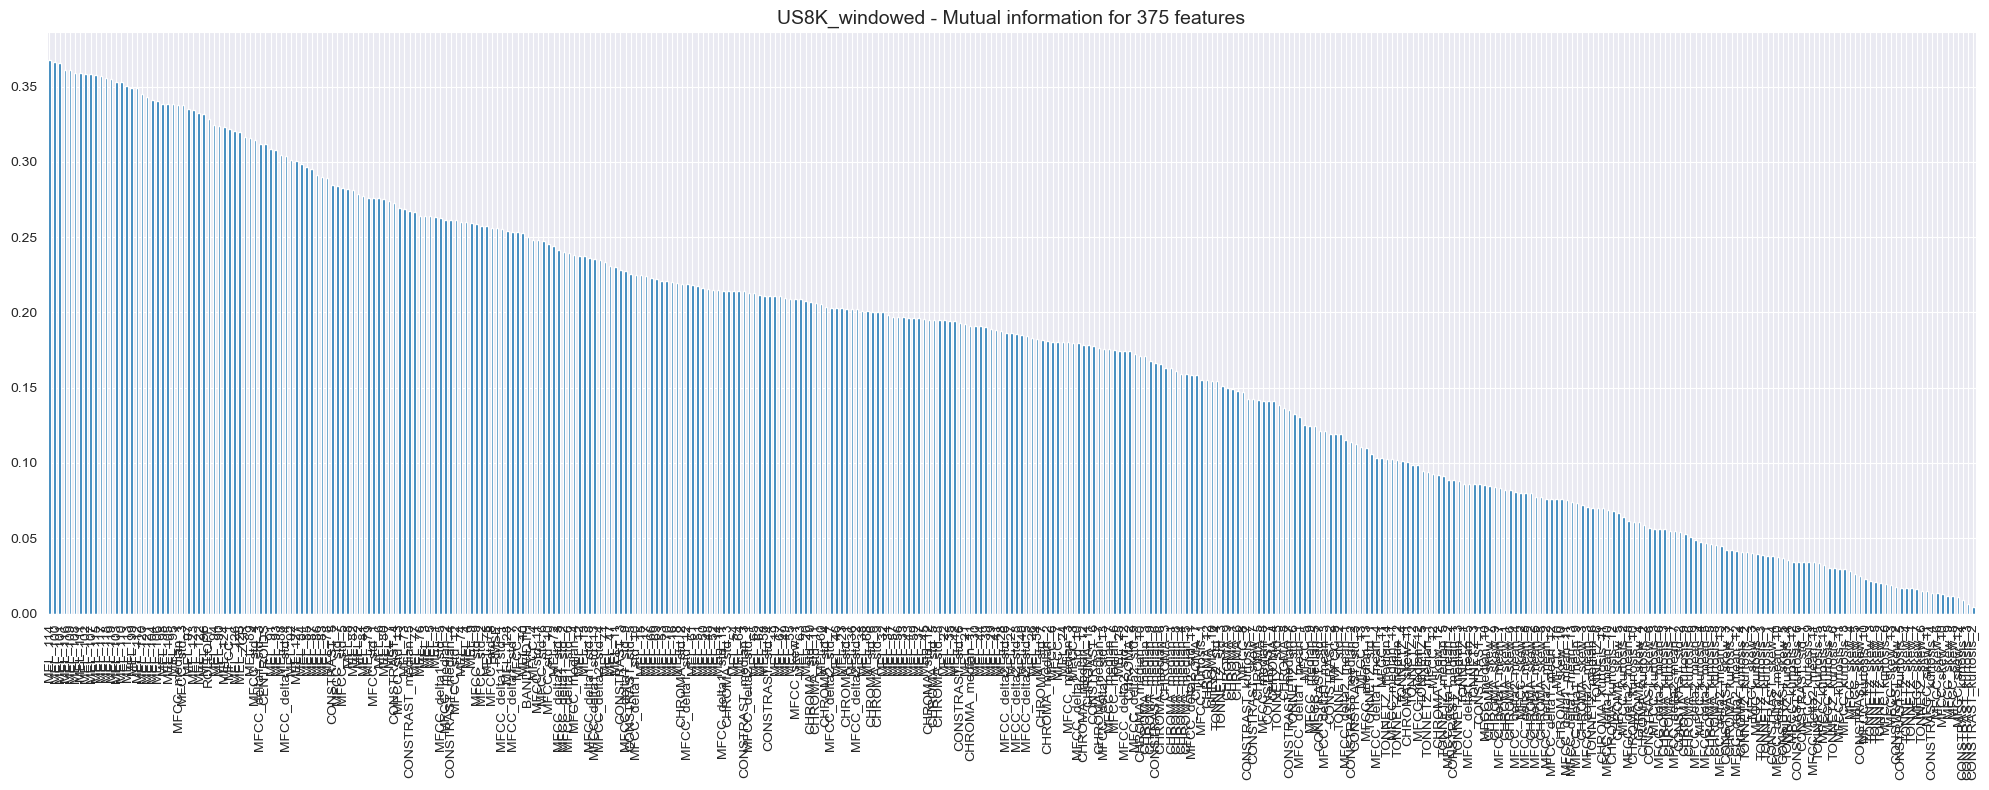

In [69]:
#Plot the sorted features based on their mutual information calculation

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(nom_dataset + model_surname + ' - Mutual information for ' + str(len(mutual_info)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

### Backup for experiments using *n* relevant features

https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [70]:
chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
f = chi2_selector.get_support(1)
f

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  33,  36,  37,  40,  41,  44,  45,  47,  48,  49,  51,  52,
        53,  54,  55,  56,  57,  59,  60,  72,  73,  83,  84,  87,  88,
        89,  91,  92,  93,  94,  95,  97,  98, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121,
       122, 123, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       139, 141, 142, 143, 144, 146, 148, 150, 151, 152, 153, 155, 157,
       159, 160, 161, 162, 166, 168, 170, 175, 177, 178, 179, 180, 184,
       186, 188, 193, 195, 196, 197, 198, 202, 204, 206, 211, 213, 215,
       220, 222, 224, 229, 231, 233, 238, 240, 242, 247, 249, 255, 257,
       260, 261, 262, 265, 266, 267, 270, 271, 272, 275, 276, 277, 283,
       284, 285, 286, 287, 289, 290, 291, 292, 294, 295, 296, 297, 299,
       300, 301, 302, 305, 306, 307, 310, 311, 312, 314, 315, 31

In [71]:
# Stores the indexes for future use
f.tofile(os.path.join(path_models, '_mutual_idx_' + nom_dataset + model_surname + '.csv'), sep=',')

In [72]:
X_new = X[X.columns[f]] # final features
X_new

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,CHROMA_12,CHROMA_std_12,CHROMA_median_12,CHROMA_kurtosis_12,TONNETZ_std_1,TONNETZ_std_2,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
0,0.117183,0.129483,2069.471399,1734.789901,2861.958452,0.000172,0.000326,0.000416,0.000709,0.000580,...,0.237895,0.149325,0.230933,0.234350,0.063006,0.054696,0.081938,0.121727,0.036064,0.025644
1,0.111724,0.131570,2098.418718,1743.608984,2885.449219,0.000047,0.000228,0.000322,0.000599,0.000533,...,0.256885,0.140828,0.243326,0.134768,0.058376,0.061673,0.087699,0.105361,0.026742,0.026433
2,0.124646,0.131459,2096.616414,1747.412264,2877.618963,0.000173,0.000376,0.000453,0.000821,0.000707,...,0.410597,0.231109,0.387785,0.102878,0.058738,0.049498,0.077355,0.112755,0.029269,0.023640
3,0.110741,0.131658,2093.378630,1736.615179,2873.214444,0.000026,0.000210,0.000282,0.000549,0.000491,...,0.256509,0.146436,0.245916,0.051214,0.048250,0.058753,0.103516,0.105685,0.026361,0.024617
4,0.125728,0.131836,2105.951159,1750.491381,2885.693914,0.000831,0.001138,0.001241,0.001559,0.001575,...,0.241773,0.121148,0.232046,0.220098,0.056431,0.059185,0.091348,0.108055,0.028995,0.024934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61119,0.012771,0.165439,2435.099768,2199.072455,4209.741211,0.041714,0.046895,0.049507,0.047384,0.039898,...,0.421407,0.279947,0.357708,-0.331310,0.050812,0.057548,0.059929,0.030278,0.021647,0.033488
61120,0.007954,0.148016,2363.629594,2317.859881,4304.193670,0.055727,0.070617,0.056094,0.040240,0.033771,...,0.509410,0.285974,0.503675,-1.015436,0.067083,0.044457,0.077088,0.039600,0.014626,0.021007
61121,0.008383,0.154519,2389.715351,2316.671469,4391.060569,0.036835,0.067511,0.118632,0.128893,0.173377,...,0.587103,0.230835,0.559486,-0.845718,0.053681,0.091874,0.038635,0.049570,0.013426,0.021124
61122,0.010459,0.173873,2467.091641,2211.234749,4411.125599,0.021755,0.042709,0.149269,0.175648,0.207281,...,0.377200,0.153873,0.342888,-0.607994,0.054311,0.059323,0.060265,0.043656,0.011971,0.027106


In [73]:
def get_mutual_info (X: pd.DataFrame, X_norm: list, y: list):
    
    mutual_info = mutual_info_classif(X_norm, y)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    mutual_info.sort_values(ascending=False)
    
    threshold = np.mean(mutual_info.sort_values(ascending=False))
    print(f' Threshold: {threshold}')
    
    count_mutual = sum(1 for element in mutual_info if element > threshold)
    print(f' Count mutual: {count_mutual}')
    
    chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
    f = chi2_selector.get_support(1)
    
    X_mutual = X[X.columns[f]] # final features

    return X_mutual

In [74]:
X_test_mutual = get_mutual_info(X, X_norm, y)

 Threshold: 0.17537441290272152
 Count mutual: 206


In [75]:
mutual_info_k_best = mutual_info_classif(X_new, y)
mutual_info_k_best

array([0.25578483, 0.31770583, 0.31150607, 0.25029064, 0.32774719,
       0.26356163, 0.27846798, 0.26379896, 0.25999903, 0.26373962,
       0.275673  , 0.27391252, 0.25957913, 0.25288725, 0.22979081,
       0.23722993, 0.23716745, 0.21502422, 0.22459705, 0.22002784,
       0.22423122, 0.21939854, 0.2109434 , 0.19463795, 0.2027946 ,
       0.18019306, 0.1744594 , 0.18916514, 0.19999209, 0.19692565,
       0.20222456, 0.19610648, 0.18485659, 0.18850053, 0.19649722,
       0.19090302, 0.19555712, 0.23048572, 0.21582535, 0.20967876,
       0.21613087, 0.21741762, 0.21513164, 0.22086188, 0.20871628,
       0.19704739, 0.20097849, 0.22234298, 0.27621511, 0.27523802,
       0.28981731, 0.29885128, 0.2965318 , 0.29553526, 0.30467169,
       0.31558185, 0.32396373, 0.30830802, 0.30793239, 0.32418189,
       0.34905003, 0.36623171, 0.36573268, 0.35853365, 0.35326723,
       0.34106374, 0.33827874, 0.34003606, 0.35852149, 0.35937245,
       0.36084711, 0.35272905, 0.35899754, 0.34873656, 0.36760

In [76]:
mutual_info_k_best       = pd.Series(mutual_info_k_best)
mutual_info_k_best.index = X_new.columns
mutual_info_k_best.sort_values(ascending=False)

MEL_114              0.367609
MEL_100              0.366232
MEL_101              0.365733
MEL_116              0.361126
MEL_109              0.360847
                       ...   
MFCC_kurtosis_3      0.056390
CHROMA_kurtosis_3    0.056221
CHROMA_kurtosis_1    0.054905
CHROMA_kurtosis_9    0.052634
CHROMA_kurtosis_6    0.050959
Length: 207, dtype: float64

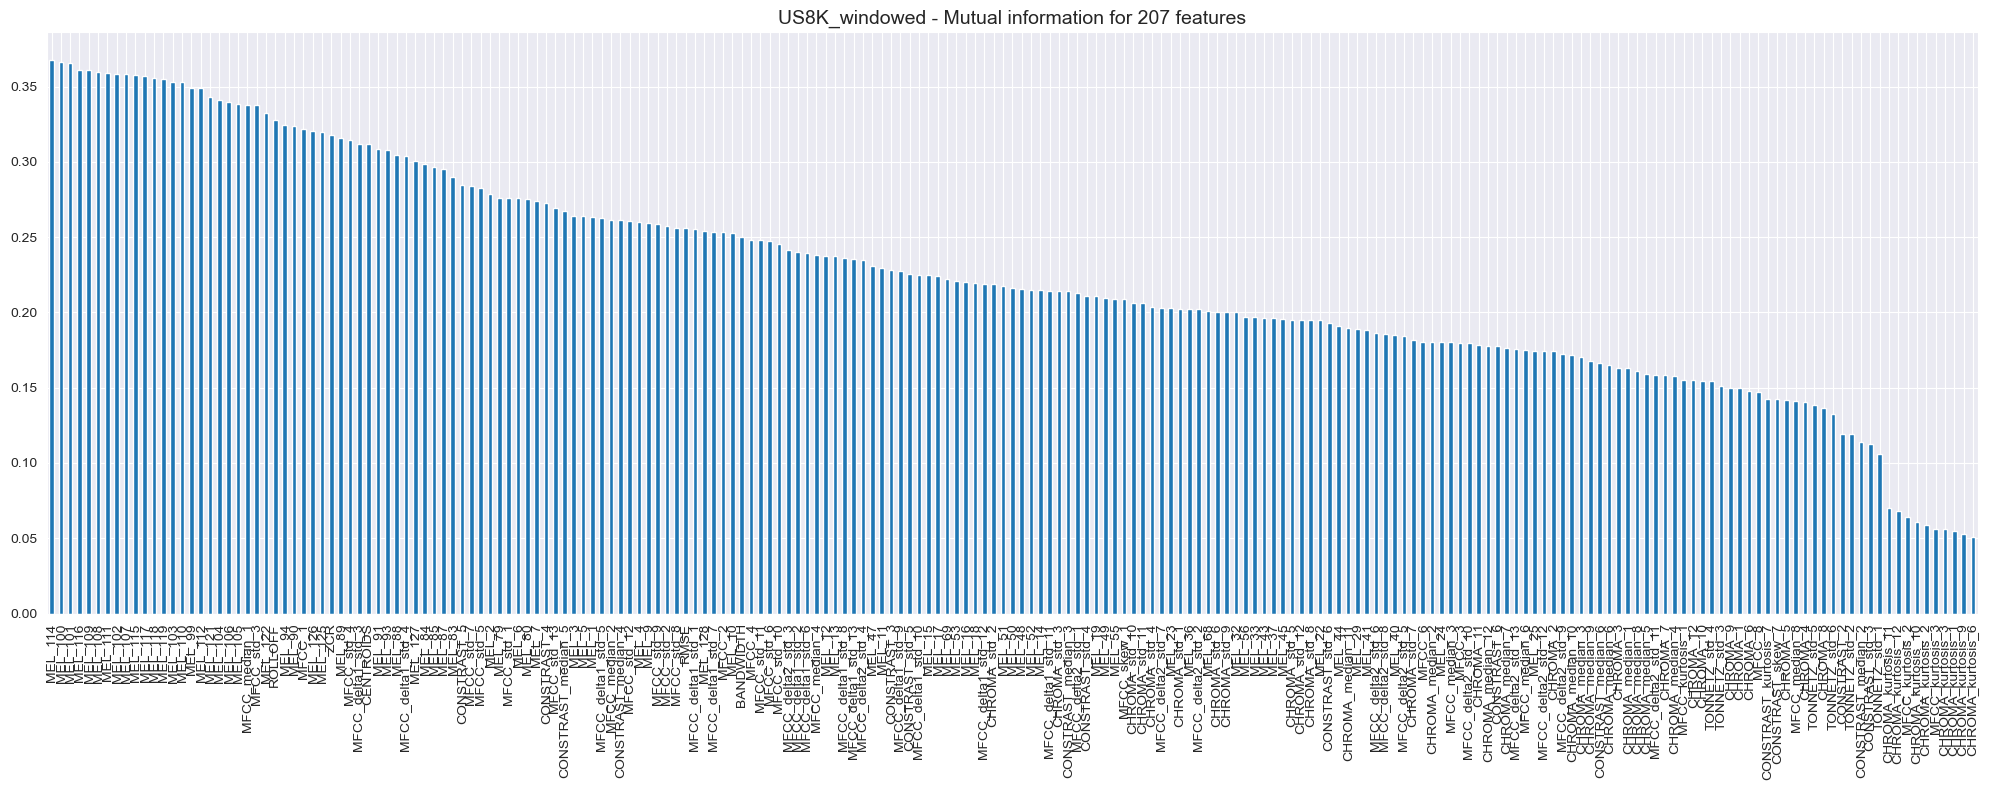

In [77]:
#Plot the sorted features based on their mutual information calculation

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

mutual_info_k_best.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(nom_dataset + model_surname + ' - Mutual information for ' + str(len(mutual_info_k_best)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

### Remark: by selection the features, re-nornamalize the dataframe

In [78]:
X_new.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,CHROMA_12,CHROMA_std_12,CHROMA_median_12,CHROMA_kurtosis_12,TONNETZ_std_1,TONNETZ_std_2,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
count,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,5.501300e+04,...,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000,55013.000000
mean,0.068962,0.119914,2126.164356,2095.301985,4096.136380,1.587649e+01,1.551829e+01,1.067019e+01,7.053240e+00,7.479396e+00,...,0.484543,0.193263,0.461395,0.485431,0.048709,0.048898,0.058112,0.057583,0.025401,0.025222
std,0.068355,0.094113,1026.349090,572.007000,2002.767161,1.005021e+02,7.051266e+01,4.155996e+01,2.696642e+01,3.234189e+01,...,0.218231,0.079834,0.250309,3.267845,0.035911,0.036404,0.046912,0.045402,0.019087,0.018768
min,0.000145,0.000000,212.399183,478.380671,202.852561,2.185136e-08,1.265428e-08,1.539058e-08,1.382298e-08,3.202950e-08,...,0.000094,0.000000,0.000002,-1.996833,0.004485,0.005708,0.005698,0.005931,0.003082,0.002233
25%,0.022730,0.059948,1411.820545,1673.140188,2561.961781,2.137662e-02,5.338410e-02,6.389216e-02,7.190919e-02,7.302918e-02,...,0.323072,0.142143,0.266389,-0.913252,0.029045,0.029135,0.032434,0.032810,0.015130,0.015174
50%,0.050379,0.092574,1871.014564,2050.329867,3670.187655,2.307109e-01,5.659199e-01,7.411505e-01,6.698897e-01,6.251277e-01,...,0.492036,0.191795,0.462032,-0.430856,0.038939,0.039512,0.044870,0.044520,0.020287,0.020268
75%,0.090281,0.142911,2574.241496,2517.625774,5432.729270,2.269010e+00,5.635880e+00,5.304951e+00,3.667604e+00,3.680416e+00,...,0.646203,0.244599,0.643485,0.523331,0.055669,0.056024,0.067076,0.066396,0.029116,0.028754
max,0.796355,0.669522,6674.189171,4340.169312,10066.772461,3.744774e+03,2.869256e+03,7.940164e+02,8.580748e+02,1.159883e+03,...,1.000000,0.496361,1.000000,39.024310,0.537298,0.503249,0.621885,0.596607,0.276190,0.257286


### Plotting the Pearson's correlation matrix

In [79]:
corr_matrix = X.corr(method='pearson')
print(corr_matrix)

                        RMSE       ZCR  CENTROIDS  BANDWIDTH   ROLLOFF     MEL_1     MEL_2     MEL_3     MEL_4     MEL_5  ...  TONNETZ_5  TONNETZ_std_5  TONNETZ_median_5  TONNETZ_skew_5  TONNETZ_kurtosis_5  TONNETZ_6  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
RMSE                1.000000 -0.013086   0.004796  -0.053031  0.003088  0.337336  0.324664  0.341809  0.340014  0.384586  ...  -0.015587       0.053160         -0.015171        0.021163            0.086293   0.008363       0.052808          0.004496        0.006520            0.050804
ZCR                -0.013086  1.000000   0.920889   0.538404  0.780838 -0.126830 -0.142706 -0.150693 -0.141788 -0.114817  ...  -0.071109      -0.087347         -0.068450        0.003431            0.049342   0.025672      -0.087981          0.027104        0.008260            0.074744
CENTROIDS           0.004796  0.920889   1.000000   0.787345  0.948799 -0.066144 -0.075739 -0.118200 -0.101913 -0.090821  ...  -0.056061      

In [80]:
opc = 0
while str(opc) not in '12':
    print()
    print("1-) Print Pearson\'s correlation heatmap.")
    print("2-) Skip printing.")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0
    
    if opc == 1:
        picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

        plt.figure(figsize=(40, 40))
        plt.title(f'{nom_dataset} - Pearson\'s correlation heatmap', fontsize = 16)
        a = sns.heatmap(corr_matrix, 
                        square=True, 
                        annot=True, 
                        fmt='.1f', 
                        linecolor='black', 
                        cbar_kws={"shrink": .80},
                        annot_kws={"fontsize":6})
        a.set_xticklabels(a.get_xticklabels(), fontsize=7)
        a.set_yticklabels(a.get_yticklabels(), fontsize=7) 
        plt.tight_layout()
        plt.savefig(os.path.join(path_pic, picture_name))
        plt.show()
    
    if opc == 2:
        pass


1-) Print Pearson's correlation heatmap.
2-) Skip printing.

Select the dataset: 2


In [81]:
# Método para visualizar a divisão do teste / treino por meio de K Fold e Stratified K Fold

def visualizar_Kfold(dataset, cv, X, y, n_splits):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
    
    sns.set_style("darkgrid")
    
    label_encoder = preprocessing.LabelEncoder()
    y_enc = label_encoder.fit_transform(y)
    y_enc = np.sort(y_enc)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Cria a visualização do treino / test para cada divisão do CV
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y_enc)):
        
        # Preenche os índices com os valores do treino / teste
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualiza os resultados
        ax.scatter(range(len(indices)),
                   [ii + 0.5] * len(indices),
                   c=indices,
                   marker="_",
                   lw=25,
                   cmap=cmap_cv,
                   vmin=-0.2,
                   vmax=1.2)

    # Imprime a linha das classes no final
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y_enc, marker="_", lw=40, cmap=cmap_data)


    # Formatação
    yticklabels = list(range(n_splits)) + ["Classes"]
    ax.set(yticks=np.arange(n_splits + 1) + 0.5,
           yticklabels=yticklabels,
           ylim=[n_splits + 1.0, 0.0],
           xlim=[0, len(y_enc)])
    
    ax.set_xlabel('Samples', fontsize=12)
    ax.set_ylabel('CV iterations', fontsize=12)
    ax.set_title("{}".format(type(cv).__name__) + " " + dataset, fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(0.8)), 
               Patch(color=cmap_cv(0.02))],
              ["Validation set", "Training set"],
              loc=(1.02, 0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

StratifiedShuffleSplit(n_splits=5, random_state=100, test_size=0.1,
            train_size=None)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
KFold(n_splits=5, random_state=None, shuffle=False)



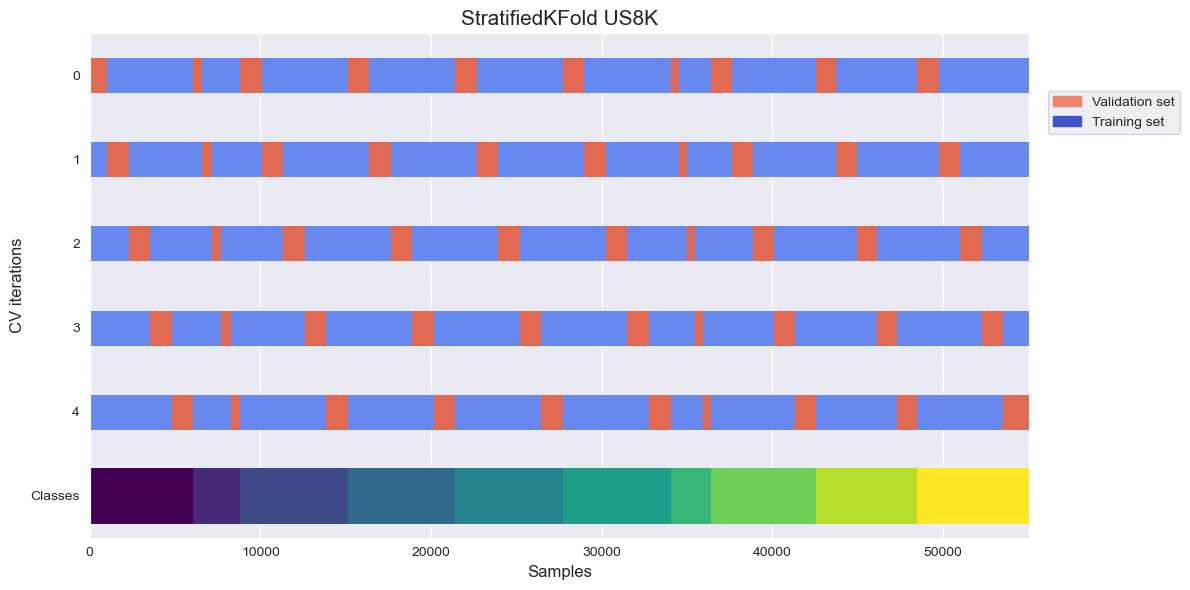

In [82]:
# Visualiza a divisão do treino / teste por meio do Stratified K Fold

print(sss)
print(skf)
print(kfd)
print()

visualizar_Kfold(nom_dataset, skf, X_norm, y, N_SPLITS)

## ML Modeling

In [83]:
del DB_from_pkl_VAL, DB_from_pkl_TRN

In [84]:
# Separate 1 fold for validation and create a DB for the training / testing

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Normalization")
    print("2-) Standardization")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0


    DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
    DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()
    
    X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
    y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

    X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
    y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

    X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

    X_mean   = X_statistics.values[:, 0]
    X_std    = X_statistics.values[:, 1]
    X_min    = X_statistics.values[:, 2]
    X_max    = X_statistics.values[:, 3]
    
    # Normalization or standardization using values from the training set.
    if opc == 1:
        X_norm     = (X.values - X_min) / (X_max - X_min)
        X_val_norm = (X_val.values - X_min) / (X_max - X_min)
        norm_type  = '_norm'

    if opc == 2:
        X_norm     = (X.values - X_mean) / X_std
        X_val_norm = (X_val.values - X_mean) / X_std
        norm_type  = '_std'
        
    # Separated training and testing for hyperparameter cross-validation (10% testing).
    # Testing was not used in this notebook, but it was in the neural networks. In order to achieve a fair comparisson,
    # the same number of samples for training were considered in both notebooks.

    for idx_trn, idx_tst in sss.split(X_norm, y):
        X_train      = X_norm[idx_trn]
        X_test       = X_norm[idx_tst]
        y_train      = y[idx_trn]
        y_test       = y[idx_tst]
        y_train_OHEV = y_OHEV[idx_trn]
        y_test_OHEV  = y_OHEV[idx_tst]
        
        # Stores the indexes for future use
        idx_trn.tofile(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), sep=',')
        idx_tst.tofile(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), sep=',')


1-) Normalization
2-) Standardization

Select the dataset: 1


In [85]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val_norm......: {np.shape(X_val_norm)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')


Training set

X_train.........: (49511, 375)
y_train.........: (49511,)
y_train_OHEV....: (49511, 10)

Testing set

X_test..........: (5502, 375)
y_test..........: (5502,)
y_test_OHEV.....: (5502, 10)

Validation set

X_val_norm......: (6111, 375)
y_val...........: (6111,)
y_OHEV_val......: (6111, 10)


In [86]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [87]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.tight_layout()

## Classifiers

- **Gaussian Naive Bayes** (GaussianNB) is a probabilistic machine learning algorithm mainly used for classification tasks based on the Naive Bayes theorem and assumes that features are independent and follow a Gaussian (normal) distribution. GaussianNB is particularly suitable for datasets with continuous or real-valued features. It calculates the probabilities of different classes for a given set of input features and assigns the class with the highest probability as the predicted class. Despite its simplifying assumption of feature independence (which is often not met in practice), GaussianNB performs surprisingly well in various real-world applications, such as text classification and spam email detection, due to its simplicity and efficiency. 
***
- The **Support Vector Classifier** (SVC)  is a supervised machine learning algorithm that is primarily used for classification tasksby finding the optimal hyperplane that best separates different classes in the input data. It does this by identifying support vectors, which are the data points closest to the decision boundary. SVC aims to maximize the margin between these support vectors and the decision boundary, making it robust to outliers and capable of handling non-linear data through the use of kernel functions. The algorithm allows for multi-class classification and can be fine-tuned through various parameters like the choice of kernel, regularization strength (C), and kernel-specific parameters. 
***
- **Logistic Regression** is a supervised machine learning algorithm that's primarily employed for binary classification tasks, though it can be extended to handle multiclass classification as well. Despite its name, it's used for classification, not regression. Logistic Regression models the probability of an instance belonging to a particular class as a logistic function of the input features. It's particularly well-suited for linearly separable data, where it tries to find a linear decision boundary that separates the two classes. Regularization techniques like L1 and L2 can be applied to prevent overfitting, while logistic regression assumes a linear relationship between features and the log-odds of the target variable, it can be effective in many practical scenarios and serves as a fundamental building block for more complex models in machine learning.
***
- The **k-Nearest Neighbors** (KNN) algorithm is a simple supervised machine learning technique used primarily for classification and regression tasks. In KNN, a data point's class or value is determined by the majority class or average of its k-nearest neighbors in the feature space. It operates under the assumption that similar data points tend to have similar class labels or target values. The choice of the "k" parameter determines how many neighboring data points are considered when making predictions; a smaller k value leads to more localized decision boundaries, while a larger k value results in smoother, global boundaries. KNN is a non-parametric algorithm, meaning it doesn't make assumptions about the underlying data distribution but it can be computationally expensive for large datasets and may require proper feature scaling and distance metric selection to perform optimally.
***
- **Random Forest** is an ensemble machine learning algorithm used for both classification and regression tasks. It's based on the concept of decision trees, but it builds multiple trees and combines their predictions to improve accuracy and reduce overfitting. In a Random Forest, a random subset of the training data and a random subset of the features are used to grow each tree. This randomness helps create diverse trees that collectively make more robust predictions. During classification, the algorithm aggregates the votes from individual trees, and for regression, it averages their predictions. Random Forest is known for its high accuracy, ability to handle large datasets with many features, and resistance to overfitting. 

In [88]:
# Plot the learning curve for the classifier

def plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std, classifier):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    plt.figsize=(30, 30)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(nom_dataset + model_surname + norm_type + ' - Learning curve for ' + classifier)
    plt.xlabel('Training data size')
    plt.ylabel('Model accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [89]:
NB_c = GaussianNB()
NB_c

GaussianNB()

In [90]:
train_sizes, train_scores, test_scores = learning_curve(estimator = NB_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 3960  7921 11882 15843 19804 23764 27725 31686 35647 39608]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   10.1s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   14.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   18.3s remaining:   42.8s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   22.8s remaining:   31.6s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   26.7s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   31.7s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   34.6s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   39.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.7s finished


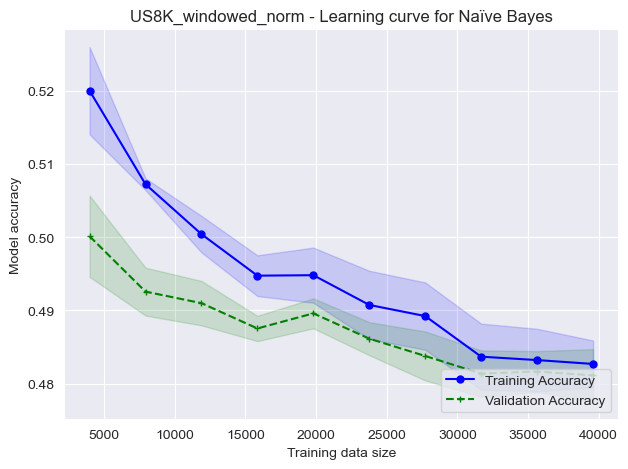

[ 3960  7921 11882 15843 19804 23764 27725 31686 35647 39608] samples were used to train the model

The average train accuracy is....: 49.47 % (+/-0.37 %)
The average test accuracy is.....: 48.75 % (+/-0.31 %)


In [91]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Naïve Bayes')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [92]:
NB_c.fit(X_train, y_train)

GaussianNB()

In [93]:
NB_c_predict = NB_c.predict(X_val_norm)

In [94]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_GaussianNB" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(NB_c, file)

In [95]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    NB_c_saved = pickle.load(file)

In [96]:
score_NB_c_saved = NB_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_NB_c_saved))
NB_c_saved_predict = NB_c_saved.predict(X_val_norm)

Test score (R2): 36.97 %


In [97]:
t_srt = time.process_time_ns()

NB_c_saved_predict_val = NB_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 296,8750 ms


In [98]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(NBC_c_saved_val_class_report)

                  precision    recall  f1-score   support

 air_conditioner       0.25      0.59      0.35       700
        car_horn       0.69      0.54      0.60       252
children_playing       0.33      0.74      0.46       700
        dog_bark       0.44      0.22      0.29       700
        drilling       0.36      0.24      0.29       700
   engine_idling       0.22      0.04      0.07       672
        gun_shot       0.57      0.27      0.37       245
      jackhammer       0.39      0.20      0.27       840
           siren       0.49      0.63      0.55       602
    street_music       0.56      0.32      0.41       700

        accuracy                           0.37      6111
       macro avg       0.43      0.38      0.37      6111
    weighted avg       0.40      0.37      0.34      6111



In [99]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)

NBC_c_saved_val_class_report_acc = NBC_c_saved_val_class_report['accuracy']
print(NBC_c_saved_val_class_report_acc)

0.3696612665684831


In [100]:
np.array_equal(NB_c_predict, NB_c_saved_predict)

True

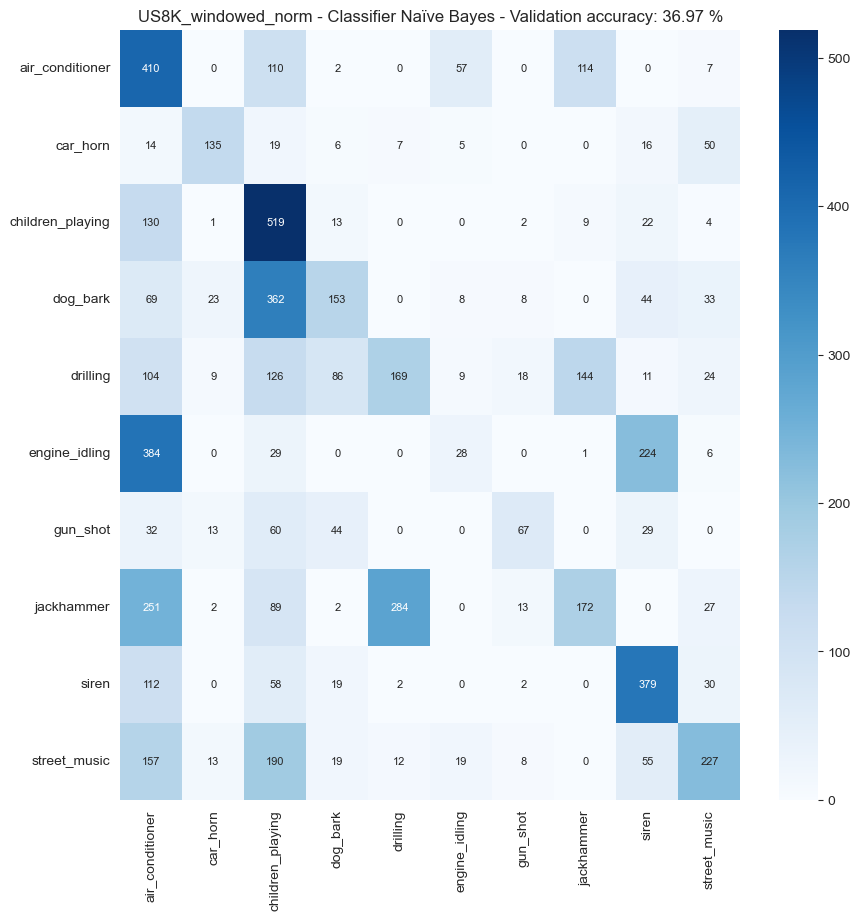

In [101]:
simple_conf_matrix(y_val, 
                   NB_c_saved_predict_val, 
                   nom_classes,
                   'Naïve Bayes',
                   NBC_c_saved_val_class_report_acc)

In [102]:
def get_random_sample(array1, array2):
    # Check if both arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Select a random index
    random_index = random.randint(0, len(array1) - 1)
    print(random_index)

    # Get the sample from the first array and the associated element from the second array
    sample = array1[random_index]
    associated_element = array2[random_index]

    # Return the result as a tuple
    return (sample, associated_element, random_index)

In [103]:
random_sample = get_random_sample(y_val, X_val_norm)

249


In [104]:
def plot_pred_sample(model, data_label, data, nom_classes):
    
    random_sample = get_random_sample(data_label, data)
    
    print(random_sample[0])
    predict_sample = model.predict([random_sample[1]])[0]

    predict_sample_proba = model.predict_proba([random_sample[1]])
    print(predict_sample)
    
    if random_sample[0] == predict_sample:
        predict_col = 'g'
    else:
        predict_col = 'r'

    # Plotting
    plt.figure(figsize = (16,6))
    plt.bar(nom_classes, predict_sample_proba[0], color = predict_col, alpha = 0.5)
    plt.xlabel('Classes')
    plt.xticks(rotation=90)
    plt.ylabel('Probabilities')
    plt.title(f'Prediction for sample: {random_sample[0]}', fontsize = 14)
    plt.show()
    return random_sample[2]

3146
air_conditioner
air_conditioner


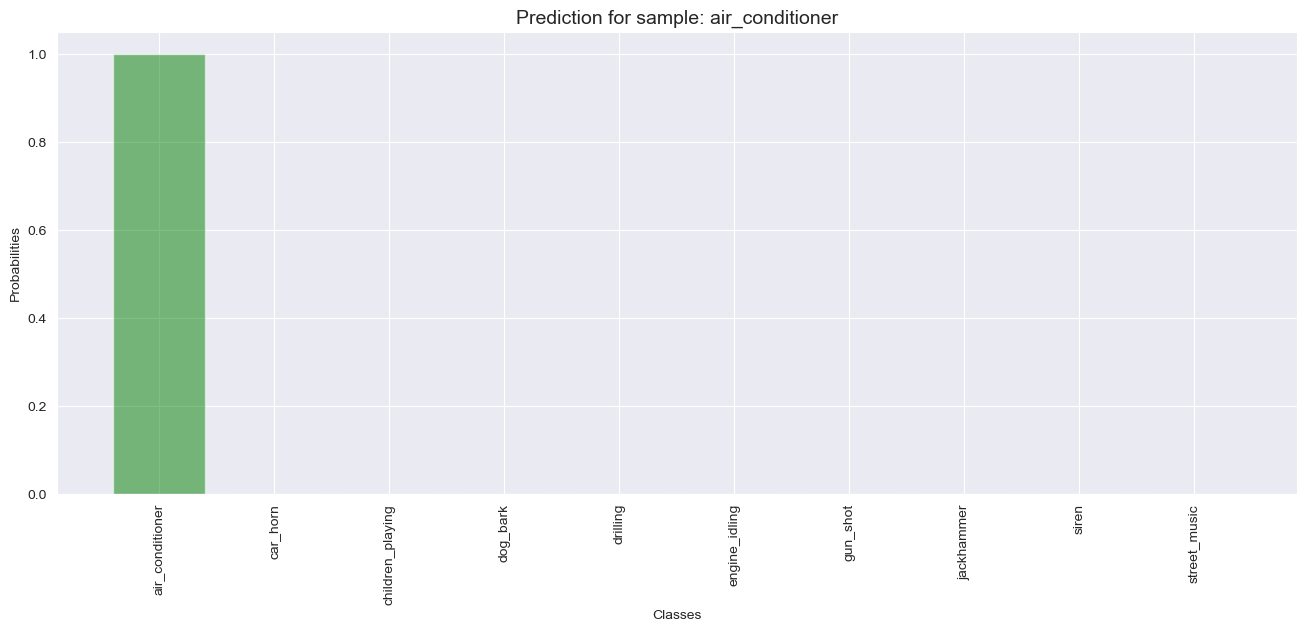

In [105]:
random_index = plot_pred_sample(NB_c_saved, y_val, X_val_norm, nom_classes)

In [106]:
print(y_val[random_index])
print(NB_c_saved.predict([X_val_norm[random_index]])[0])

air_conditioner
air_conditioner


In [107]:
# Testing hyperparameters for SVC classifier - After several test, the hyperparameters were set

#SVC_hp = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
#          'degree': [9, 15, 20],
#          'C':[0.010, 0.030, 0.1, 0.2, 0.5], 
#          'probability': [True, False],
#          'random_state': [SEED]}

#grid_SVC = GridSearchCV(SVC(), SVC_hp, refit = True, verbose=3)

#grid_SVC.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_SVC.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_SVC.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_SVC.best_params_)

In [108]:
#grid_SVC.best_params_

In [109]:
# degree = degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.

SVC_c = SVC(kernel       = 'linear',
            degree       = 9,  
            C            = 0.5, 
            probability  = True, 
            random_state = SEED,
            verbose      = True)
SVC_c

SVC(C=0.5, degree=9, kernel='linear', probability=True, random_state=1000,
    verbose=True)

In [110]:
train_sizes, train_scores, test_scores = learning_curve(estimator = SVC_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 7921 11442 14963 18483 22004 25525 29045 32566 36087 39608]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed: 10.3min remaining: 161.1min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed: 32.9min remaining: 149.7min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 54.2min remaining: 126.6min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 80.9min remaining: 111.7min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 97.8min remaining: 83.3min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 119.8min remaining: 61.7min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 148.5min remaining: 41.9min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 168.6min remaining: 18.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 181.8min finished


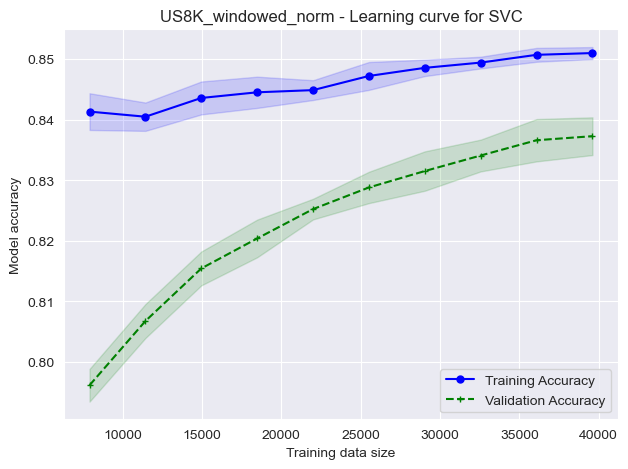

[ 7921 11442 14963 18483 22004 25525 29045 32566 36087 39608] samples were used to train the model

The average train accuracy is....: 84.61 % (+/-0.19 %)
The average test accuracy is.....: 82.32 % (+/-0.28 %)


In [111]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'SVC')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [112]:
SVC_c.fit(X_train, y_train)

[LibSVM]

SVC(C=0.5, degree=9, kernel='linear', probability=True, random_state=1000,
    verbose=True)

In [113]:
SVC_c_predict = SVC_c.predict(X_val_norm)

In [114]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_SVC" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(SVC_c, file)

In [115]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    SVC_c_saved = pickle.load(file)

In [116]:
score_SVC_c_saved = SVC_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_SVC_c_saved))
SVC_c_saved_predict = SVC_c_saved.predict(X_val_norm)

Test score (R2): 64.56 %


In [117]:
t_srt = time.process_time_ns()

SVC_c_saved_predict_val = SVC_c_saved.predict(X_val_norm)
2
t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 28562,5000 ms


In [118]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(SVC_c_saved_val_class_report)

                  precision    recall  f1-score   support

 air_conditioner       0.57      0.43      0.49       700
        car_horn       0.64      0.87      0.74       252
children_playing       0.58      0.82      0.68       700
        dog_bark       0.74      0.78      0.76       700
        drilling       0.59      0.56      0.58       700
   engine_idling       0.60      0.48      0.54       672
        gun_shot       0.59      0.91      0.72       245
      jackhammer       0.70      0.61      0.65       840
           siren       0.83      0.65      0.73       602
    street_music       0.63      0.65      0.64       700

        accuracy                           0.65      6111
       macro avg       0.65      0.68      0.65      6111
    weighted avg       0.65      0.65      0.64      6111



In [119]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
SVC_c_saved_val_class_report_acc = SVC_c_saved_val_class_report['accuracy']
SVC_c_saved_val_class_report_acc

0.6455571919489446

In [120]:
np.array_equal(SVC_c_predict, SVC_c_saved_predict)

True

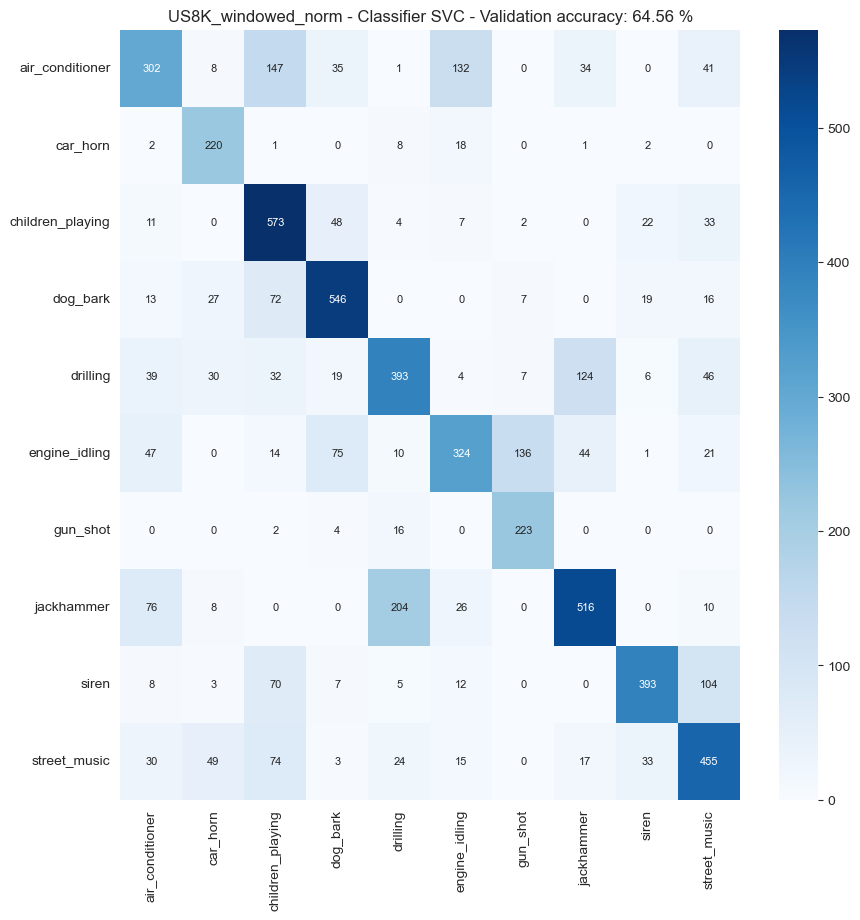

In [121]:
simple_conf_matrix(y_val, 
                   SVC_c_saved_predict_val, 
                   nom_classes,
                   'SVC',
                   SVC_c_saved_val_class_report_acc)

1194
children_playing
dog_bark


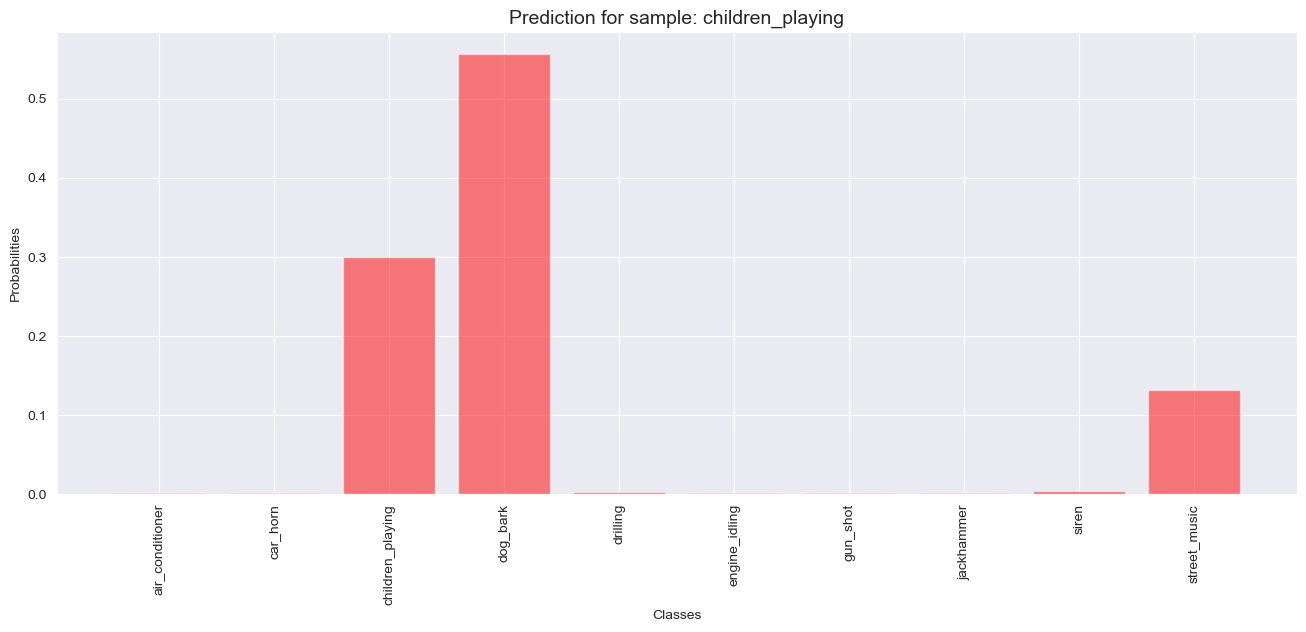

In [122]:
random_index = plot_pred_sample(SVC_c_saved, y_val, X_val_norm, nom_classes)

In [123]:
print(random_index)
print(y_val[random_index])
print(SVC_c_saved.predict([X_val_norm[random_index]])[0])

1194
children_playing
dog_bark


In [124]:
# Testing hyperparameters for Logistic Regression classifier - After several test, the hyperparameters were set

#LogisticR_hp = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
#                'penalty': ['l1', 'l2', 'elasticnet', None],
#                'max_iter':[100, 150, 200, 500],
#                'C':[0.010, 0.030, 0.1, 0.2, 0.5]}

#grid_LogisticR = GridSearchCV(LogisticRegression(), LogisticR_hp, refit = True, verbose=3)

#grid_LogisticR.fit(X_train, y_train)

#print(" Results from Grid Search in the Logistic Regression classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_LogisticR.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_LogisticR.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_LogisticR.best_params_)

In [125]:
#grid_LogisticR.best_params_

In [126]:
LogisticR_c = LogisticRegression(solver    = 'saga', 
                                 C         = 0.5, 
                                 max_iter  = 500,
                                 verbose   = 10,
                                 n_jobs    = -1)
LogisticR_c

LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga', verbose=10)

In [127]:
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticR_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 7921 11442 14963 18483 22004 25525 29045 32566 36087 39608]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  1.5min remaining: 23.4min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  3.6min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  5.2min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  6.6min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  8.0min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  9.5min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 11.4min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 13.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.4min finished


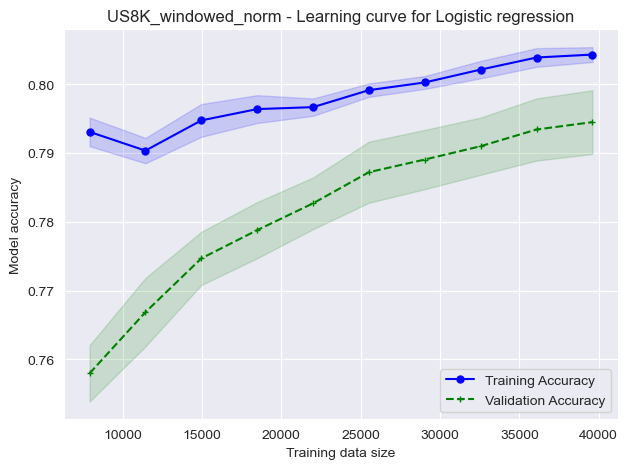

[ 7921 11442 14963 18483 22004 25525 29045 32566 36087 39608] samples were used to train the model

The average train accuracy is....: 79.81 % (+/-0.15 %)
The average test accuracy is.....: 78.16 % (+/-0.43 %)


In [128]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Logistic regression')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [129]:
LogisticR_c.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 274 epochs took 191 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.2min finished


LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga', verbose=10)

In [130]:
LogisticR_c_predict = LogisticR_c.predict(X_val_norm)

In [131]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_LogisticR" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(LogisticR_c, file)

In [132]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    LogisticR_c_saved = pickle.load(file)

In [133]:
score_LogisticR_c_saved = LogisticR_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_LogisticR_c_saved))
LogisticR_c_saved_predict = LogisticR_c_saved.predict(X_val_norm)

Test score (R2): 66.96 %


In [134]:
t_srt = time.process_time_ns()

LogisticR_c_saved_predict_val = LogisticR_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 0,0000 ms


In [135]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = False)
print(LogisticR_c_saved_val_class_report)

                  precision    recall  f1-score   support

 air_conditioner       0.66      0.49      0.56       700
        car_horn       0.67      0.85      0.75       252
children_playing       0.64      0.80      0.71       700
        dog_bark       0.84      0.77      0.80       700
        drilling       0.68      0.48      0.56       700
   engine_idling       0.60      0.51      0.56       672
        gun_shot       0.49      0.90      0.63       245
      jackhammer       0.70      0.79      0.75       840
           siren       0.82      0.71      0.76       602
    street_music       0.57      0.64      0.60       700

        accuracy                           0.67      6111
       macro avg       0.67      0.69      0.67      6111
    weighted avg       0.68      0.67      0.67      6111



In [136]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = True)
LogisticR_c_saved_val_class_report_acc = LogisticR_c_saved_val_class_report['accuracy']
LogisticR_c_saved_val_class_report_acc

0.6696121747668139

In [137]:
np.array_equal(LogisticR_c_predict, LogisticR_c_saved_predict)

True

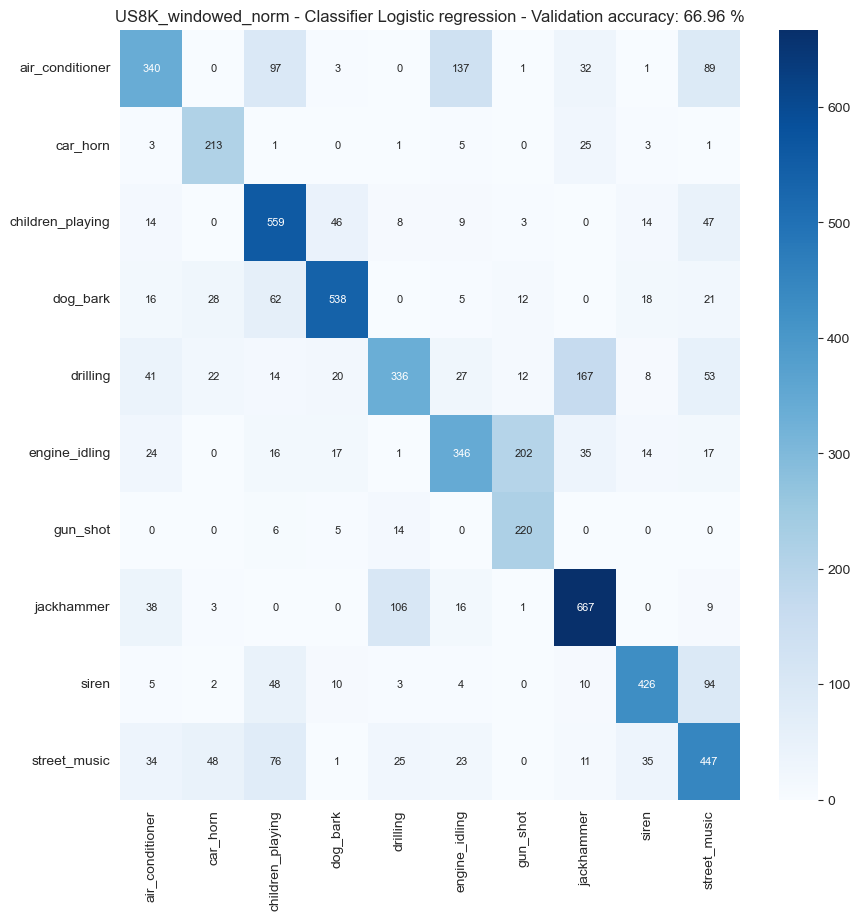

In [138]:
simple_conf_matrix(y_val, 
                   LogisticR_c_saved_predict_val, 
                   nom_classes,
                   'Logistic regression',
                   LogisticR_c_saved_val_class_report_acc)

3864
car_horn
drilling


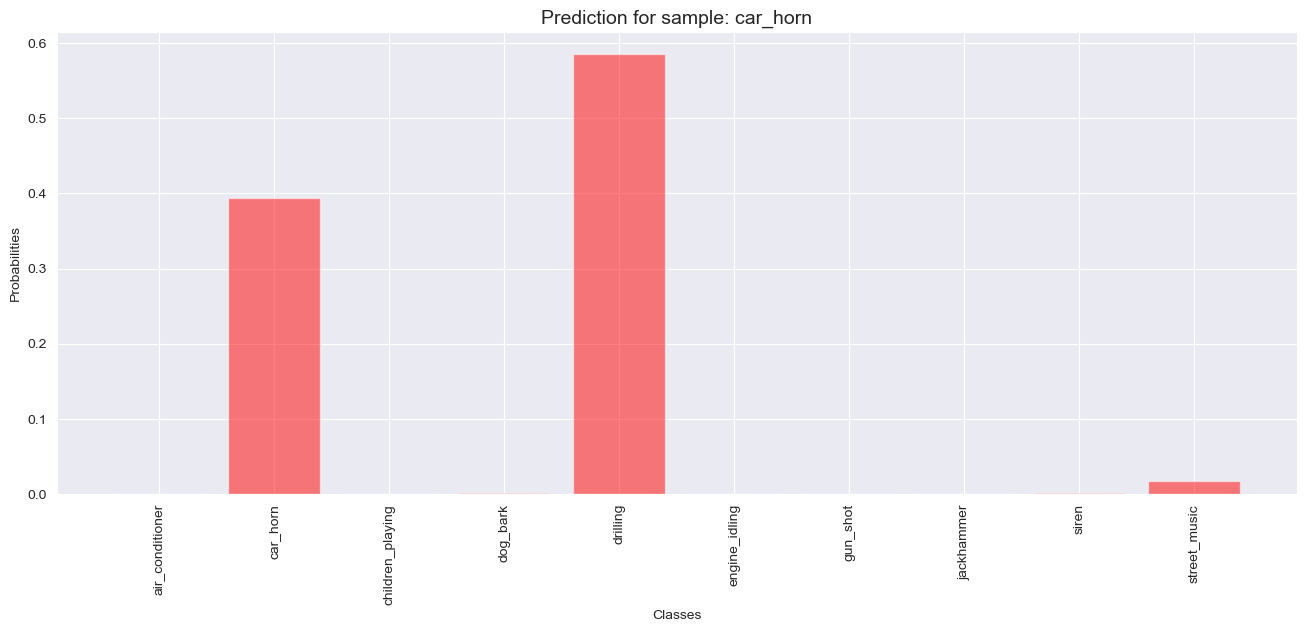

In [139]:
random_index = plot_pred_sample(LogisticR_c_saved, y_val, X_val_norm, nom_classes)

In [140]:
print(y_val[random_index])
print(LogisticR_c_saved.predict([X_val_norm[random_index]])[0])

car_horn
drilling


In [141]:
# Testing hyperparameters for KNN classifier - After several test, the hyperparameters were set

#KNN_hp = {'n_neighbors':[3, 5, 8, 12], 
#          'metric': ['mahalanobis', 'euclidean', 'minkowski'],
#          'p':[1, 2], 
#          'leaf_size': [20, 40, 80]}

#grid_KNN = GridSearchCV(KNeighborsClassifier(), KNN_hp, refit = True, verbose=3)

#grid_KNN.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_KNN.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_KNN.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_KNN.best_params_)

In [142]:
#grid_KNN.best_params_

In [143]:
KNN_c = KNeighborsClassifier(n_neighbors = 3,
                             metric      = 'minkowski',
                             p           = 2,
                             leaf_size   = 20,
                             n_jobs      = -1)
KNN_c

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)

In [144]:
train_sizes, train_scores, test_scores = learning_curve(estimator = KNN_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 3960  7921 11882 15843 19804 23764 27725 31686 35647 39608]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    9.3s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   29.8s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   51.5s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  1.2min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  1.7min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  1.9min remaining:   59.2s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  2.4min remaining:   40.3s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  2.8min remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


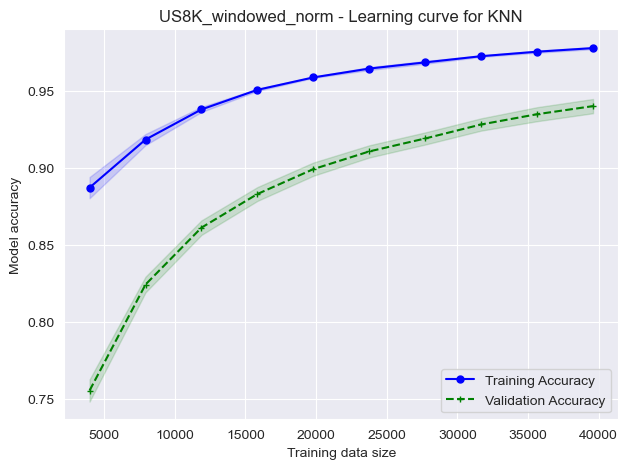

[ 3960  7921 11882 15843 19804 23764 27725 31686 35647 39608] samples were used to train the model

The average train accuracy is....: 95.10 % (+/-0.17 %)
The average test accuracy is.....: 88.54 % (+/-0.47 %)


In [145]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'KNN')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [146]:
KNN_c.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)

In [147]:
KNN_c_predict = KNN_c.predict(X_val_norm)

In [148]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_KNN" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(KNN_c, file)

In [149]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    KNN_c_saved = pickle.load(file)

In [150]:
score_KNN_c_saved = KNN_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_KNN_c_saved))
KNN_c_saved_predict = KNN_c_saved.predict(X_val_norm)

Test score (R2): 48.73 %


In [151]:
t_srt = time.process_time_ns()

KNN_c_saved_predict_val = KNN_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 9343,7500 ms


In [152]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(KNN_c_saved_val_class_report)

                  precision    recall  f1-score   support

 air_conditioner       0.13      0.09      0.10       700
        car_horn       0.54      0.77      0.63       252
children_playing       0.40      0.75      0.52       700
        dog_bark       0.52      0.60      0.55       700
        drilling       0.46      0.48      0.47       700
   engine_idling       0.47      0.37      0.41       672
        gun_shot       0.89      0.90      0.89       245
      jackhammer       0.36      0.23      0.28       840
           siren       0.78      0.71      0.74       602
    street_music       0.63      0.50      0.56       700

        accuracy                           0.49      6111
       macro avg       0.52      0.54      0.52      6111
    weighted avg       0.48      0.49      0.47      6111



In [153]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
KNN_c_saved_val_class_report_acc = KNN_c_saved_val_class_report['accuracy']
KNN_c_saved_val_class_report_acc

0.487317951235477

In [154]:
np.array_equal(KNN_c_predict, KNN_c_saved_predict)

True

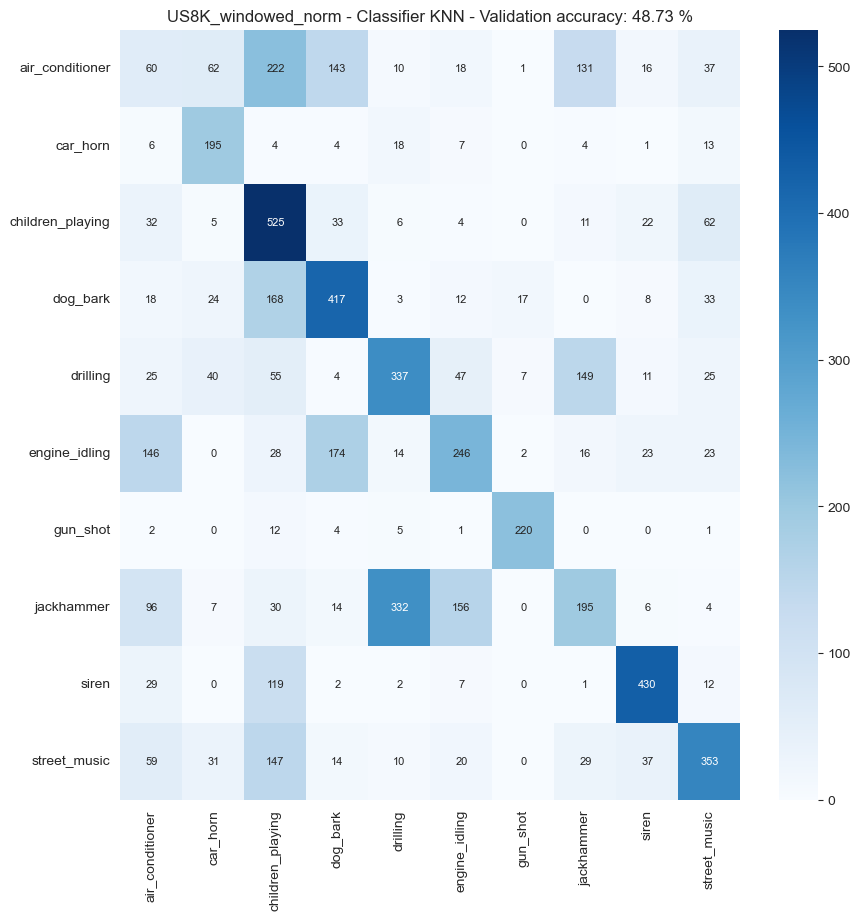

In [155]:
simple_conf_matrix(y_val, 
                   KNN_c_saved_predict_val, 
                   nom_classes,
                   'KNN',
                   KNN_c_saved_val_class_report_acc)

1976
siren
siren


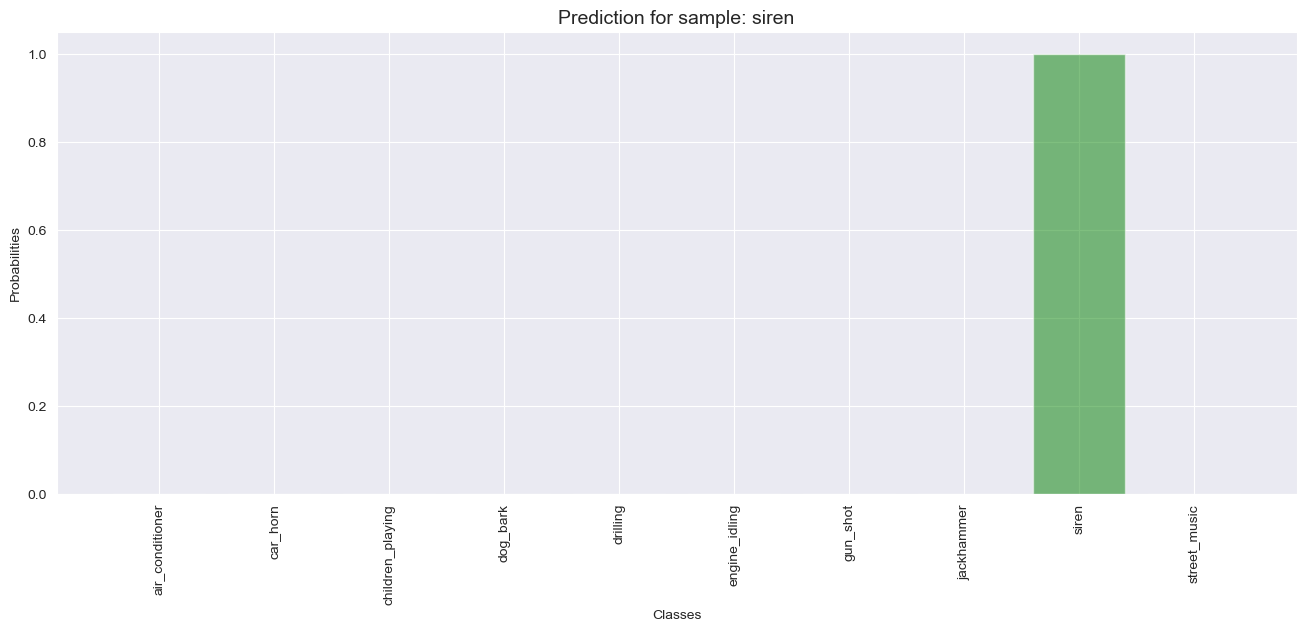

In [156]:
random_index = plot_pred_sample(KNN_c_saved, y_val, X_val_norm, nom_classes)

In [157]:
print(y_val[random_index])
print(KNN_c_saved.predict([X_val_norm[random_index]])[0])

siren
siren


In [158]:
# Testing hyperparameters for random forest classifier (ensemble method) - After several test, the hyperparameters were set

#forest_hp = {'n_estimators':[10, 25, 50, 100, 200, 500], 
#             'criterion': ['gini', 'entropy', 'log_loss'],
#             'bootstrap':[True, False]}

#grid_forest = GridSearchCV(RandomForestClassifier(), forest_hp, refit = True, verbose=3)

#grid_forest.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_forest.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_forest.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_forest.best_params_)

In [159]:
#grid_forest.best_params_

In [160]:
forest_c = RandomForestClassifier(criterion    = 'gini',
                                  n_estimators = 500,
                                  bootstrap    = True,
                                  n_jobs       = -1,
                                  verbose      = 10)
forest_c

RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=10)

In [161]:
train_sizes, train_scores, test_scores = learning_curve(estimator = forest_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 3960  7921 11882 15843 19804 23764 27725 31686 35647 39608]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  9.7min remaining: 151.3min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed: 13.2min remaining: 60.2min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 22.2min remaining: 51.7min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 28.8min remaining: 39.8min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 36.8min remaining: 31.3min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 41.6min remaining: 21.4min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 48.4min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 55.5min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 59.0min finished


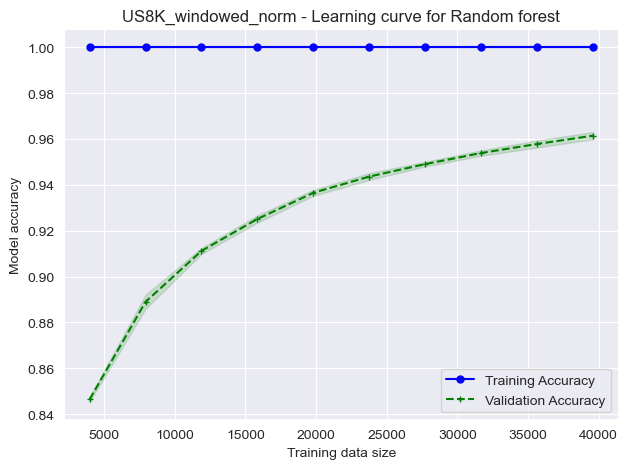

[ 3960  7921 11882 15843 19804 23764 27725 31686 35647 39608] samples were used to train the model

The average train accuracy is....: 100.00 % (+/-0.00 %)
The average test accuracy is.....: 92.74 % (+/-0.15 %)


In [162]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Random forest')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [163]:
forest_c.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 500building tree 2 of 500
building tree 3 of 500
building tree 4 of 500

building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s


building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.1s


building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s


building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s


building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.8s


building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   21.1s


building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   25.7s


building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   30.2s


building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   34.8s


building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   40.6s


building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   48.9s


building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500


[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   56.3s


building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500


[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.0min


building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min


building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500


[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  1.3min


building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500


[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  1.4min


building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500
building tree 253 of 500
building tree 254 of 500


[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:  1.5min


building tree 255 of 500
building tree 256 of 500
building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.7min


building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500


[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  1.8min


building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500


[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:  2.0min


building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.1min


building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500


[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  2.3min


building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500


[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  2.5min


building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500building tree 438 of 500

building tree 439 of 500


[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.7min


building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500


[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  2.9min


building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=10)

In [164]:
forest_c_predict = forest_c.predict(X_val_norm)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

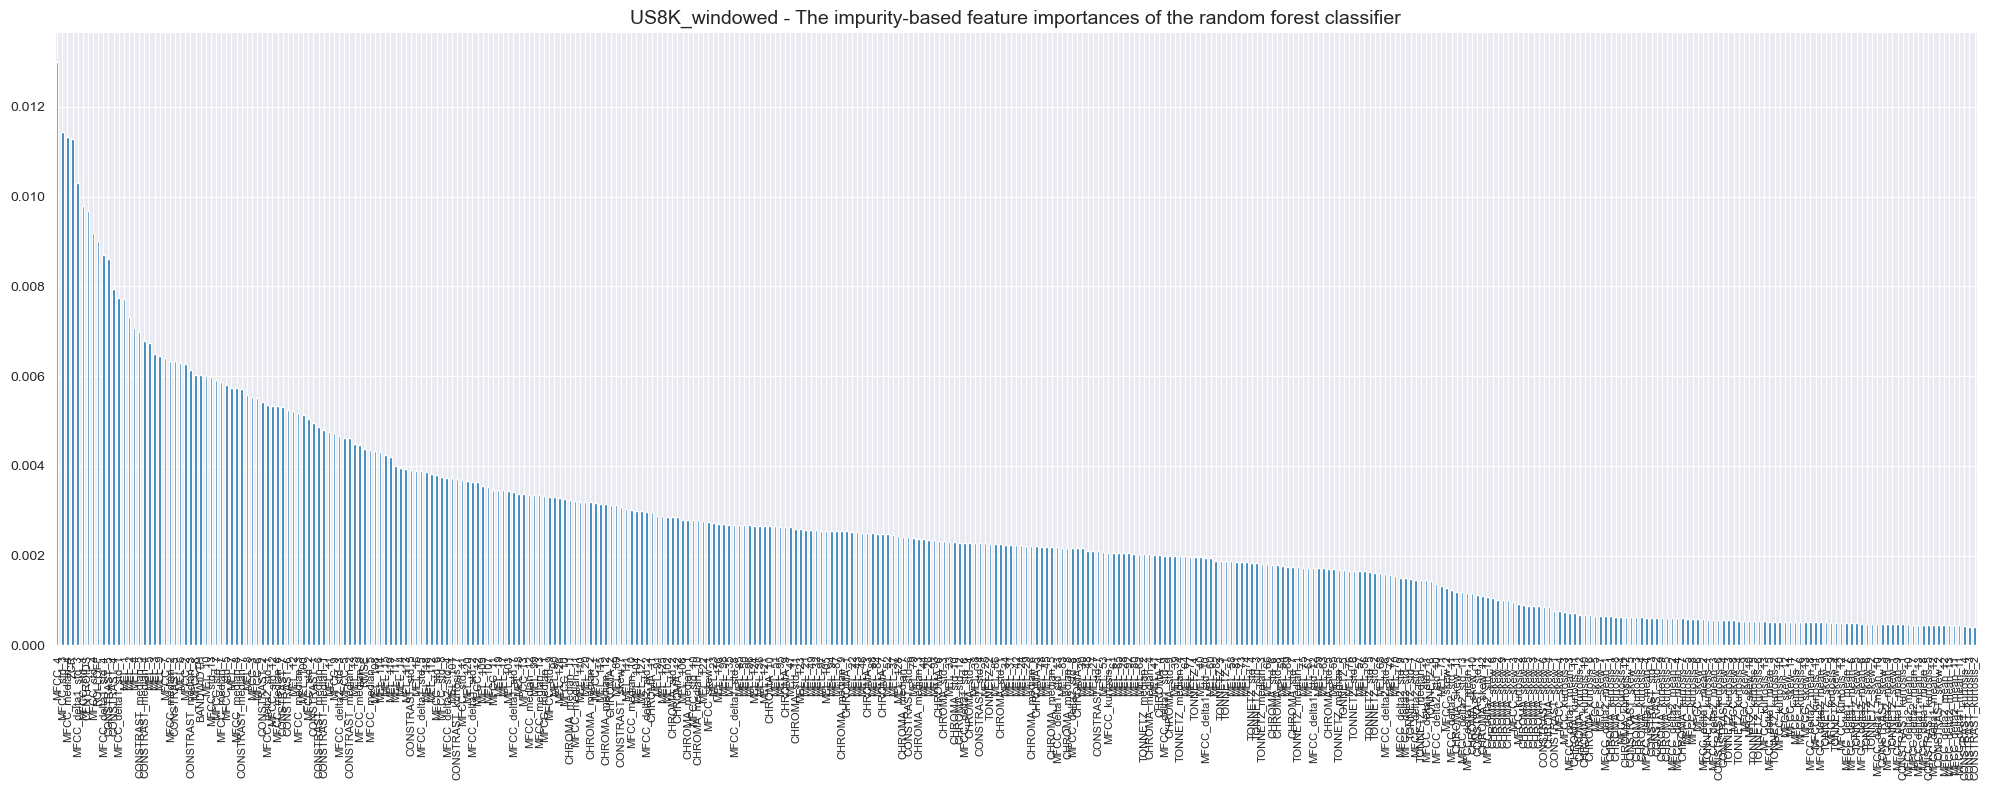

In [165]:
# Plot the feature importances of the random forest classifier

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
plt.figure(num=None, figsize=(20,8), facecolor='w', edgecolor='k')
feat_importances = pd.Series(forest_c.feature_importances_, index= X.columns)
temp_feature     = feat_importances.nlargest(375).reset_index()
rff = feat_importances.nlargest(375).plot(kind='bar')
rff.set_xticklabels(temp_feature['index'], fontsize=8)
plt.title(nom_dataset + model_surname + ' - The impurity-based feature importances of the random forest classifier', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [166]:
feat_importances.nlargest(375).sum()

1.0

In [167]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_Forest" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(forest_c, file)

In [168]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    forest_c_saved = pickle.load(file)

In [169]:
score_forest_c_saved = forest_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_forest_c_saved))
forest_c_saved_predict = forest_c_saved.predict(X_val_norm)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

Test score (R2): 61.92 %


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

In [170]:
t_srt = time.process_time_ns()

forest_c_saved_predict_val = forest_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

Processing time: 1656,2500 ms


[Parallel(n_jobs=12)]: Done 397 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished


In [171]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = False)
print(forest_c_saved_val_class_report)

                  precision    recall  f1-score   support

 air_conditioner       0.66      0.16      0.26       700
        car_horn       0.88      0.78      0.83       252
children_playing       0.53      0.79      0.63       700
        dog_bark       0.56      0.80      0.66       700
        drilling       0.51      0.71      0.60       700
   engine_idling       0.66      0.54      0.59       672
        gun_shot       0.97      0.74      0.84       245
      jackhammer       0.68      0.37      0.48       840
           siren       0.84      0.78      0.81       602
    street_music       0.58      0.77      0.66       700

        accuracy                           0.62      6111
       macro avg       0.69      0.64      0.63      6111
    weighted avg       0.65      0.62      0.60      6111



In [172]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = True)
forest_c_saved_val_class_report_acc = forest_c_saved_val_class_report['accuracy']
forest_c_saved_val_class_report_acc

0.6192112583865161

In [173]:
np.array_equal(forest_c_predict, forest_c_saved_predict)

True

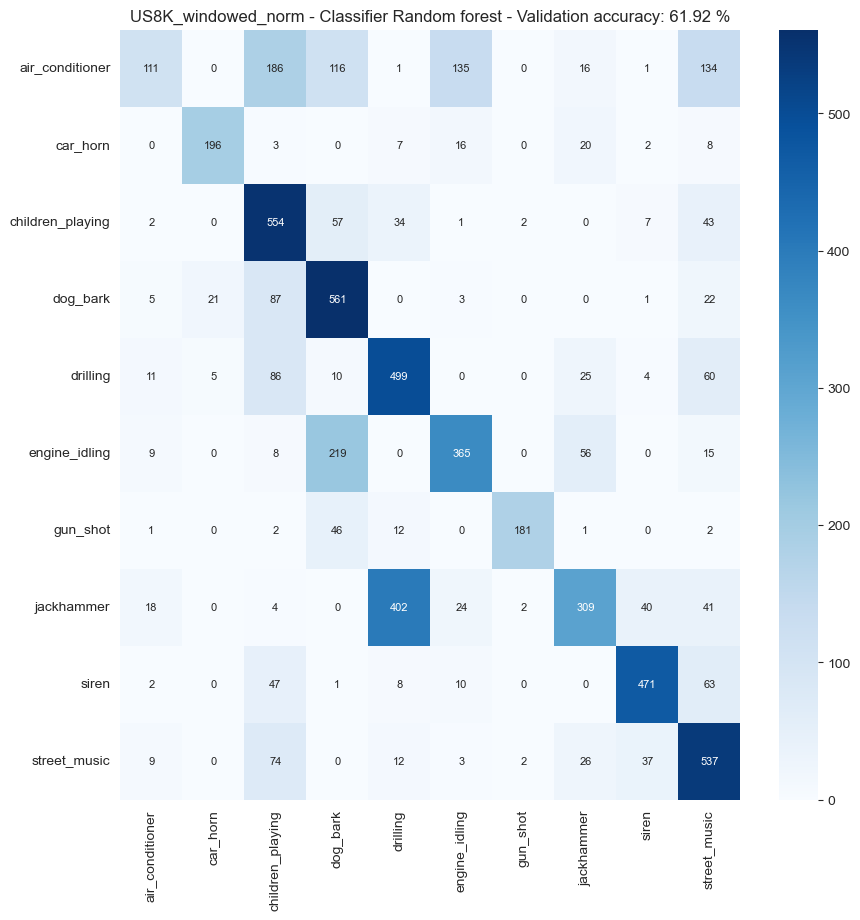

In [174]:
simple_conf_matrix(y_val, 
                   forest_c_saved_predict_val, 
                   nom_classes,
                   'Random forest',
                   forest_c_saved_val_class_report_acc)

3675
jackhammer
drilling


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

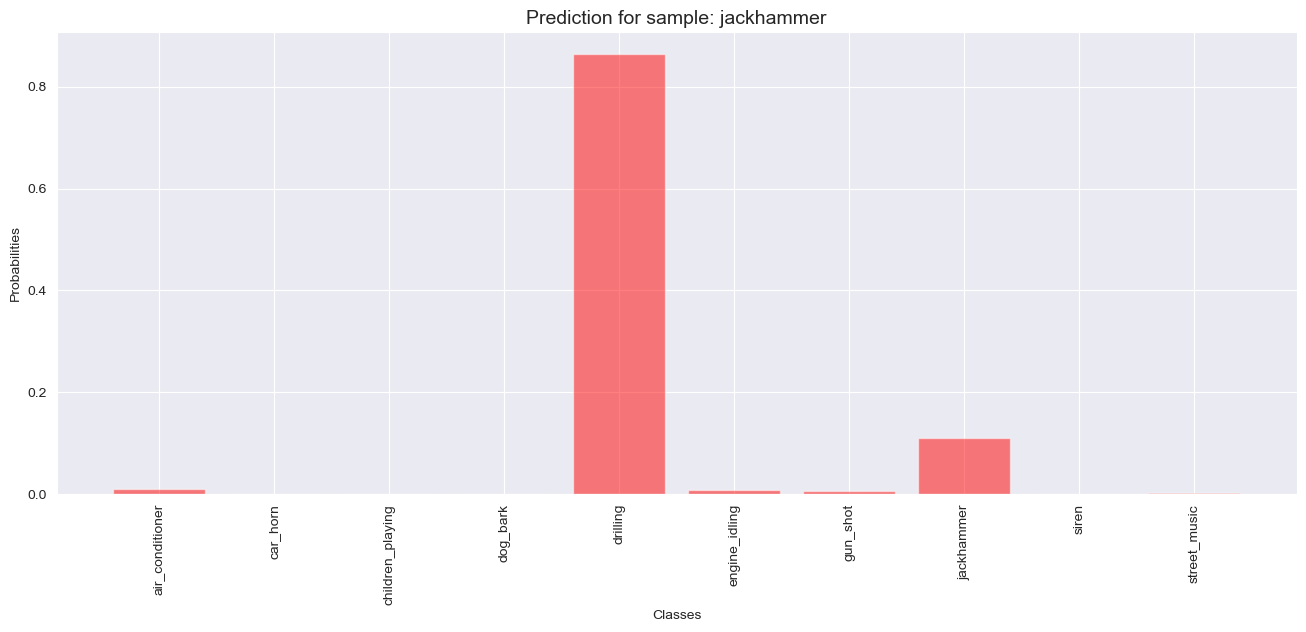

In [175]:
random_index = plot_pred_sample(forest_c_saved, y_val, X_val_norm, nom_classes)

In [176]:
print(y_val[random_index])
print(forest_c_saved.predict([X_val_norm[random_index]])[0])

jackhammer
drilling


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

### Evaluating a voting classifier for the ML algorithms

In [177]:
labels = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN']

In [178]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c], labels):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Naïves Bayes  Accuracy: 48.11 % (+/- 0.36 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 30.7min remaining: 46.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 30.7min remaining: 20.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.9min finished


SVC  Accuracy: 83.72 % (+/- 0.31 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


Logistic regression  Accuracy: 79.45 % (+/- 0.46 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


KNN  Accuracy: 93.99 % (+/- 0.46 %)


In [179]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'hard',
                                   n_jobs = -1,
                                   verbose = True)

In [180]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'soft',
                                   n_jobs = -1,
                                   verbose = True)

In [181]:
# Save the classifier to file in the current working directory

pkl_filename_hard = "Model_voting_hard" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename_hard), 'wb') as file:
    pickle.dump(voting_clf_hard, file)

In [182]:
# Save the classifier to file in the current working directory

pkl_filename_soft = "Model_voting_soft" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename_soft), 'wb') as file:
    pickle.dump(voting_clf_soft, file)

In [183]:
labels_new = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN', 'Random forest', 'Voting hard', 'Voting soft']

In [184]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename_hard), 'rb') as file:
    voting_clf_hard_saved = pickle.load(file)

In [185]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename_soft), 'rb') as file:
    voting_clf_soft_saved = pickle.load(file)

In [186]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard, voting_clf_soft], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Naïves Bayes  Accuracy: 48.11 % (+/- 0.36 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 30.4min remaining: 45.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 30.5min remaining: 20.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.5min finished


SVC  Accuracy: 83.72 % (+/- 0.31 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


Logistic regression  Accuracy: 79.45 % (+/- 0.46 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.8s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


KNN  Accuracy: 93.99 % (+/- 0.46 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.2min remaining: 16.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 11.2min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min finished


Random forest  Accuracy: 96.13 % (+/- 0.17 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 30.8min remaining: 46.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.0min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.1min finished


Voting hard  Accuracy: 84.55 % (+/- 0.33 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 30.7min remaining: 46.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.0min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.0min finished


Voting soft  Accuracy: 87.28 % (+/- 0.34 %)


In [187]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard_saved, voting_clf_soft_saved], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, "Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Naïves Bayes Accuracy: 48.11 % (+/- 0.36 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 30.3min remaining: 45.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 30.4min remaining: 20.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.4min finished


SVC Accuracy: 83.72 % (+/- 0.31 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


Logistic regression Accuracy: 79.45 % (+/- 0.46 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.7s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


KNN Accuracy: 93.99 % (+/- 0.46 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.1min remaining: 16.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 11.2min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min finished


Random forest Accuracy: 96.09 % (+/- 0.17 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 31.0min remaining: 46.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.0min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.0min finished


Voting hard Accuracy: 84.55 % (+/- 0.33 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 31.0min remaining: 46.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.0min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.1min finished


Voting soft Accuracy: 87.28 % (+/- 0.34 %)


In [188]:
voting_clf_hard_saved.fit(X_train, y_train)

VotingClassifier(estimators=[('Naïves Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, degree=9, kernel='linear',
                                  probability=True, random_state=1000,
                                  verbose=True)),
                             ('Logistic regression',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga', verbose=10)),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 n_jobs=-1, verbose=True)

In [189]:
t_srt = time.process_time_ns()

votingHard_c_saved_predict_val = voting_clf_hard_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 38812,5000 ms


In [190]:
votingHard_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingHard_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = False)
print(votingHard_c_saved_val_class_report)

                  precision    recall  f1-score   support

 air_conditioner       0.40      0.52      0.45       700
        car_horn       0.68      0.90      0.77       252
children_playing       0.51      0.86      0.64       700
        dog_bark       0.79      0.66      0.72       700
        drilling       0.54      0.56      0.55       700
   engine_idling       0.62      0.40      0.49       672
        gun_shot       0.60      0.92      0.73       245
      jackhammer       0.65      0.44      0.52       840
           siren       0.85      0.71      0.77       602
    street_music       0.73      0.55      0.63       700

        accuracy                           0.61      6111
       macro avg       0.64      0.65      0.63      6111
    weighted avg       0.64      0.61      0.61      6111



In [191]:
votingHard_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingHard_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = True)
votingHard_c_saved_val_class_report_acc = votingHard_c_saved_val_class_report['accuracy']
votingHard_c_saved_val_class_report_acc

0.6079201440026182

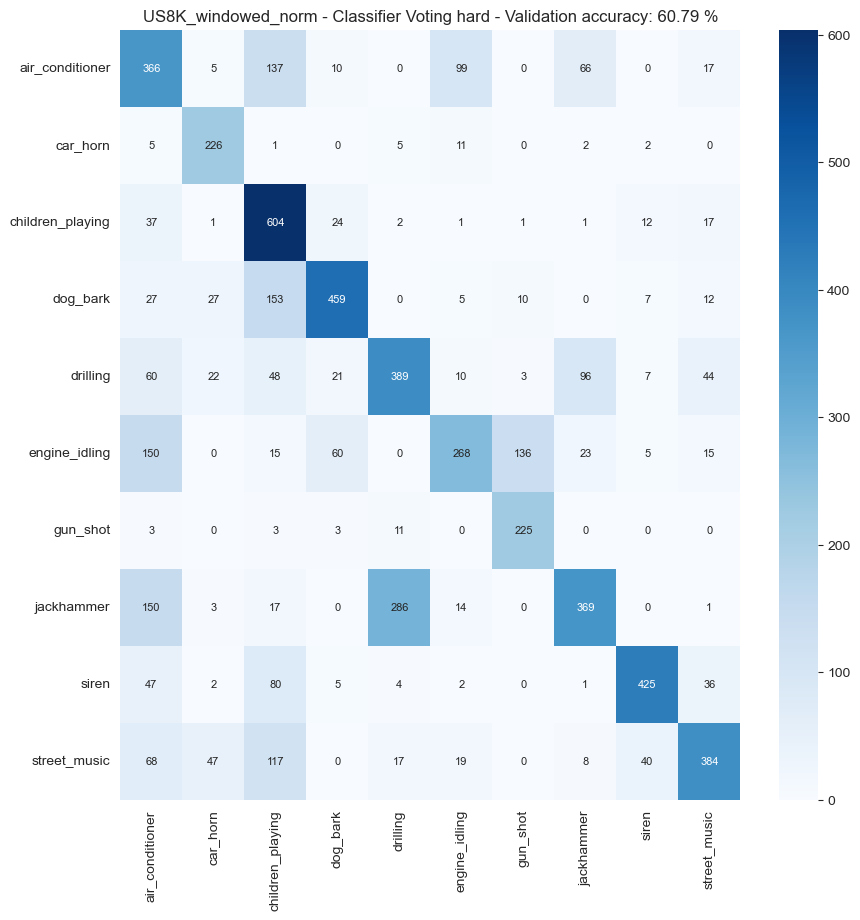

In [192]:
simple_conf_matrix(y_val, 
                   votingHard_c_saved_predict_val, 
                   nom_classes,
                   'Voting hard',
                   votingHard_c_saved_val_class_report_acc)

In [193]:
voting_clf_soft_saved.fit(X_train, y_train)

VotingClassifier(estimators=[('Naïves Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, degree=9, kernel='linear',
                                  probability=True, random_state=1000,
                                  verbose=True)),
                             ('Logistic regression',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga', verbose=10)),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 n_jobs=-1, verbose=True, voting='soft')

In [194]:
t_srt = time.process_time_ns()

votingSoft_c_saved_predict_val = voting_clf_soft_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 38390,6250 ms


In [195]:
votingSoft_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingSoft_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = False)
print(votingSoft_c_saved_val_class_report)

                  precision    recall  f1-score   support

 air_conditioner       0.46      0.54      0.49       700
        car_horn       0.74      0.90      0.82       252
children_playing       0.52      0.85      0.65       700
        dog_bark       0.81      0.69      0.75       700
        drilling       0.54      0.52      0.53       700
   engine_idling       0.67      0.43      0.52       672
        gun_shot       0.59      0.95      0.72       245
      jackhammer       0.57      0.44      0.50       840
           siren       0.81      0.74      0.78       602
    street_music       0.72      0.57      0.64       700

        accuracy                           0.62      6111
       macro avg       0.64      0.66      0.64      6111
    weighted avg       0.64      0.62      0.62      6111



In [196]:
votingSoft_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingSoft_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = True)
votingSoft_c_saved_val_class_report_acc = votingSoft_c_saved_val_class_report['accuracy']
votingSoft_c_saved_val_class_report_acc

0.6193748977254132

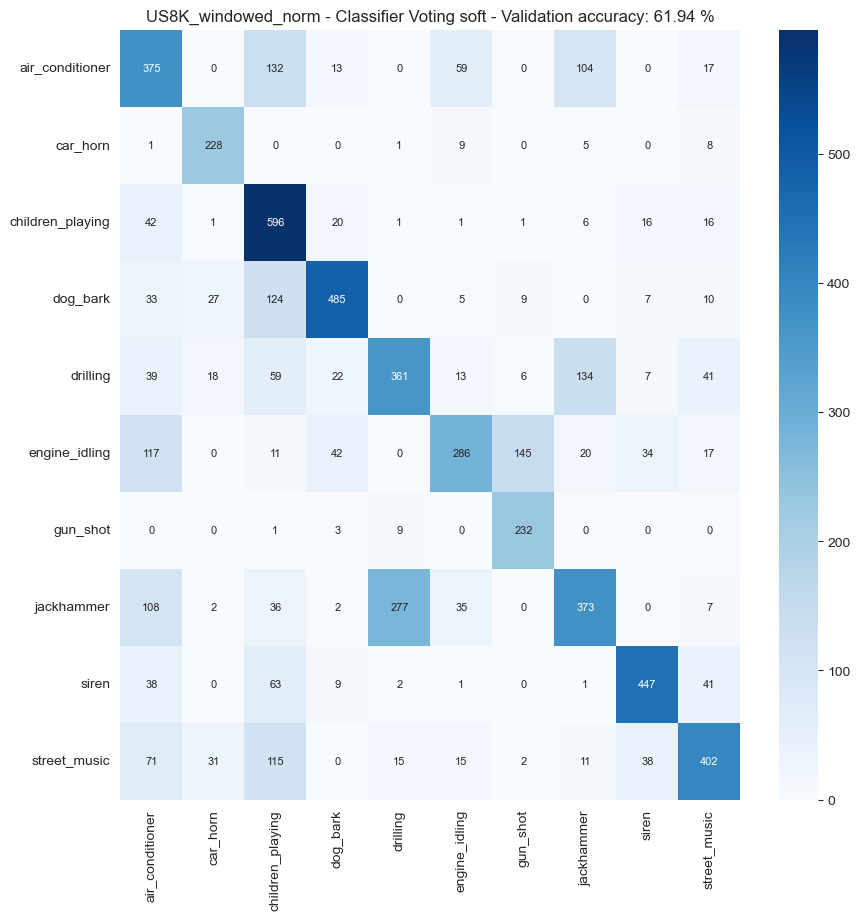

In [197]:
simple_conf_matrix(y_val, 
                   votingSoft_c_saved_predict_val, 
                   nom_classes,
                   'Voting soft',
                   votingSoft_c_saved_val_class_report_acc)

# End of notebook